# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

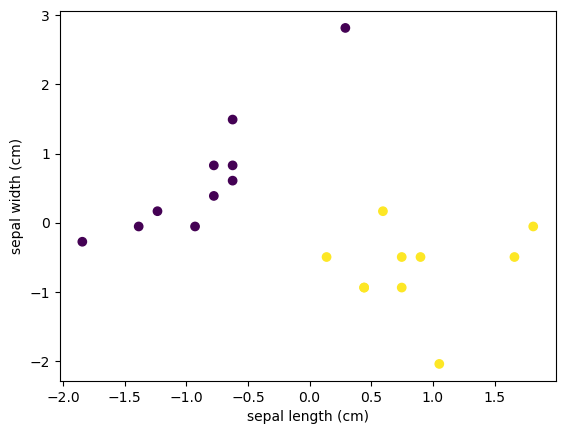

In [4]:
n = 20
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b'] + [f'u_{i}' for i in range(1, 11)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.015120983123779297
Optimal objective value: 1.5032354142068518
SCS solver iterations: 225
SCS solve time: 0.002507651
SCS setup time: 0.001651456
Optimal w:  [ 1.57543572 -0.72420516]
Optimal b:  [0.42400222]
Dual variables (Lagrange multipliers): [1.50323262 0.09050162 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.41273087 0.         0.         0.         0.
 0.         0.        ]
Constraints: [-0.00000045  0.00000239 -0.07999933 -2.559997   -2.32001    -1.280001
 -0.39999723 -0.79999965 -0.15999657 -0.15998313 -0.7200041  -0.79999965
 -0.9600031  -0.00000209 -1.2000037  -0.6399934  -2.400007   -0.64000237
 -1.2800071  -0.24000558]


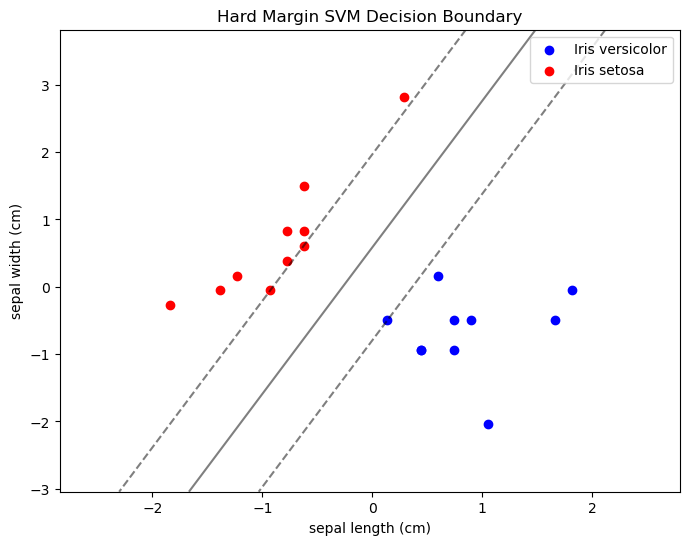

In [7]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [8]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 1.503244
Constraints: [ 0.000224   -0.00053923 -0.08042105 -2.5602448  -2.3192916  -1.2798469
 -0.40060228 -0.7999021  -0.16062984 -0.16161078 -0.72012955 -0.7999021
 -0.9596657  -0.00021225 -1.1996381  -0.6409017  -2.3995004  -0.6402477
 -1.2799562  -0.23942146]
max diff: 0.0016276538 mean diff: 0.0016276538
w diff: [0.00018532 0.0004149 ] b diff: [0.00040528]


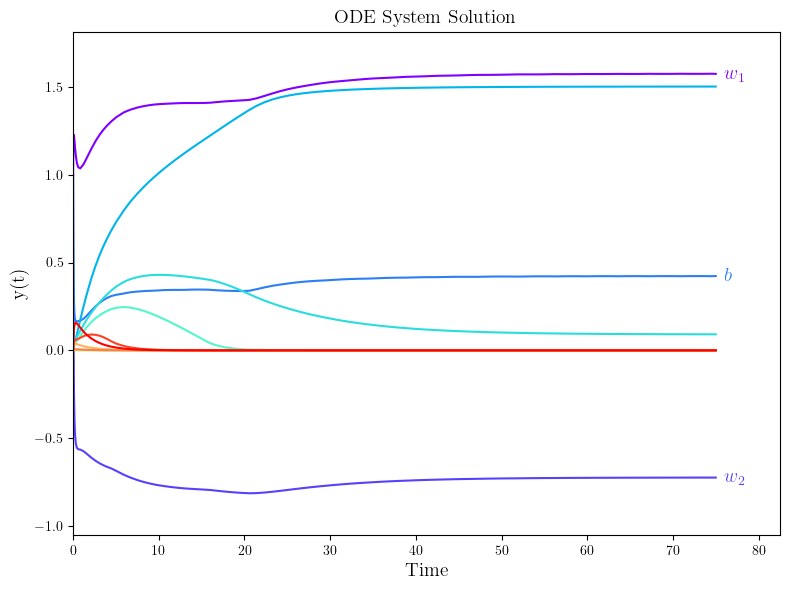

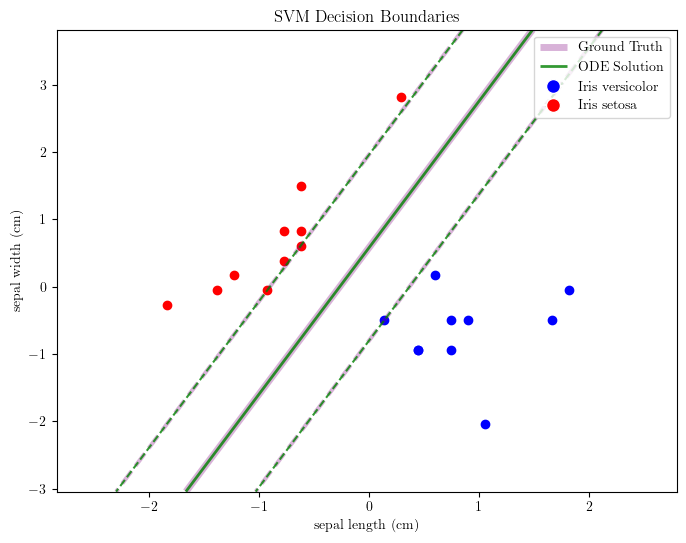

In [10]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 75)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

# 3. The method

In [11]:
T=20.0

In [12]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [13]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*((t / T).detach().reshape((-1, ))**2))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        FIXED_PENALTY = 1.0
        PENALTY_SCALE = 2.0
        epsilon = 1e-3
        
        x = y[:, :nx].cpu().detach().numpy()
        g_values = torch.tensor(g_batch(x)).cuda()
        
        penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
        
        logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()
        
        constraint_loss = torch.sum(logarithmic_penalty, axis=1) # [NBATCH]
        constraint_weight  = torch.exp(-WEIGTHING * ((1 - t / T).detach().reshape((-1,))**2))
        constraint_loss = constraint_weight * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [14]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [15]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          non_inifinty_ratio = len([num for num in L_epsilon_curr if not  np.isinf(num)]) / len(L_epsilon_curr)
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'ratio:', non_inifinty_ratio, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'mse': mse_, 'ratio': non_inifinty_ratio, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [16]:
T=20.0
NBATCH = 512
ITERATIONS = 1000
NEURONS=100
LR=0.01
LAYERS=2
hyperparameter_combinations = []

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 42.811047 MSE solution: 19.234484107026912 ratio: 0.011 time: 107.8782205581665
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 34.6907 MSE solution: 15.238696949664032 ratio: 0.018 time: 109.13778924942017
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6037873 MSE solution: 0.006758589375908672 ratio: 0.014 time: 109.45592331886292
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0941377 MSE solution: 0.07340056806299966 ratio: 0.007 time: 108.19673895835876
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5185137 MSE solution: 3.3858024781411515e-05 ratio: 0.025 time: 105.96036386489868
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5661966 MSE solution: 0.022585985792282274 ratio: 0.018 time: 105.45934438705444
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8635577 MSE solution: 0.029601940312901743 ratio: 0.002 time: 107.59464049339294
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 23.005705 MSE solution: 9.603586572808508 ratio: 0.013 time: 106.87005090713501
LAYERS: 2 NEURONS

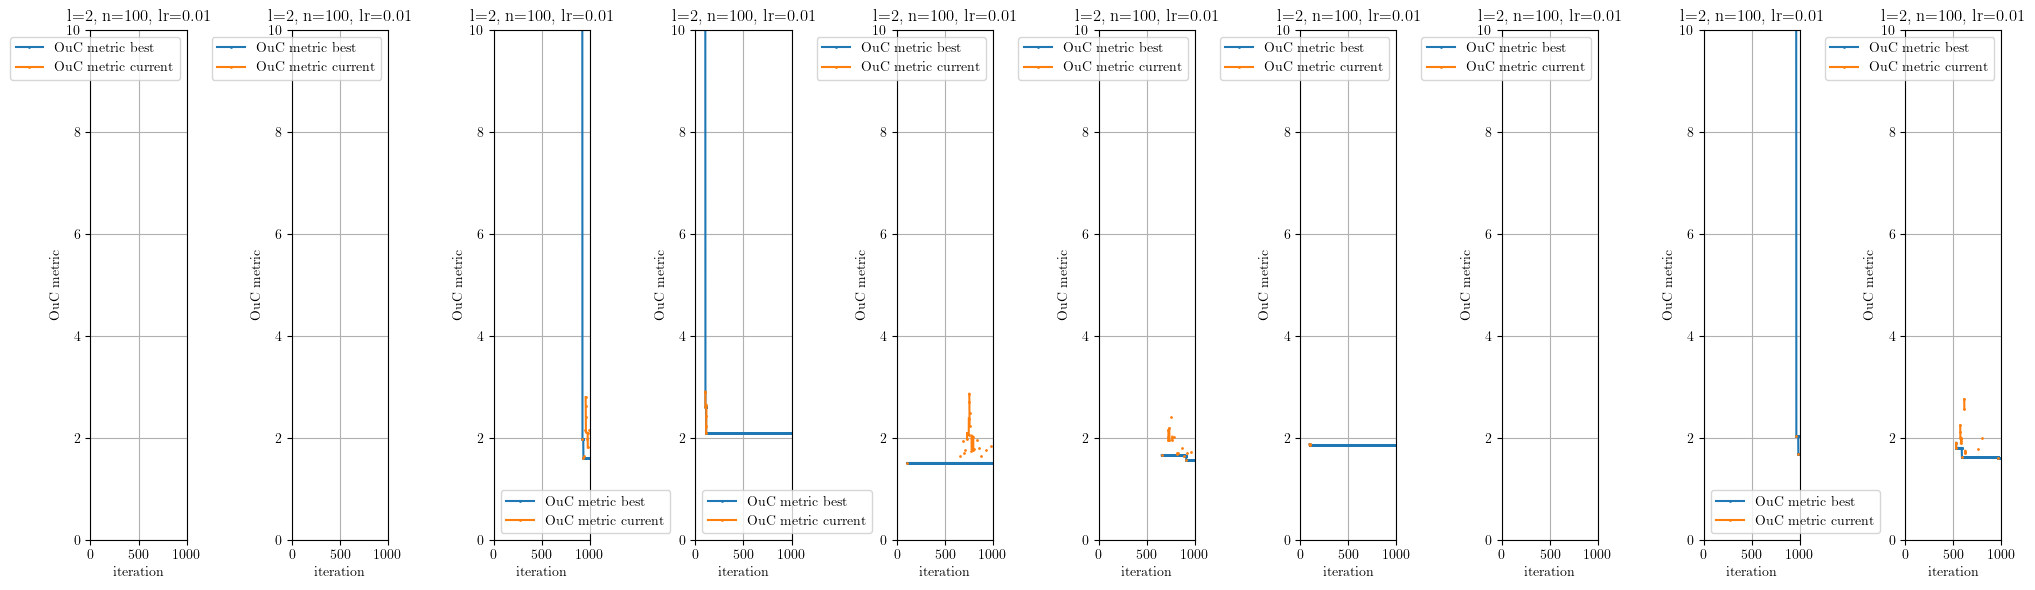

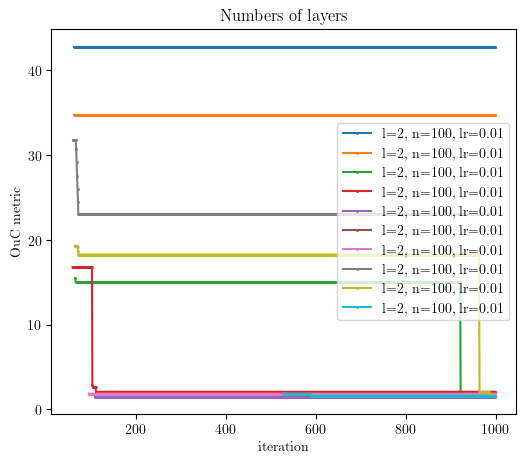

In [17]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6129454 MSE solution: 0.032333389184234465 ratio: 0.004 time: 107.5478527545929
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5901784 MSE solution: 0.00446094715259243 ratio: 0.017 time: 101.7792980670929
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5705066 MSE solution: 0.003738306583521566 ratio: 0.031 time: 97.22192597389221
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.177735 MSE solution: 0.08312821950790701 ratio: 0.008 time: 96.7478837966919
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5763181 MSE solution: 0.009905471405070579 ratio: 0.019 time: 98.22545409202576
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5717943 MSE solution: 0.01762884919843909 ratio: 0.014 time: 97.3907630443573
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6910591 MSE solution: 0.015032836541289965 ratio: 0.024 time: 108.93909311294556
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5747395 MSE solution: 0.005536094141808928 ratio: 0.011 time: 102.93955945968628
LAYERS: 2 NEURONS: 1

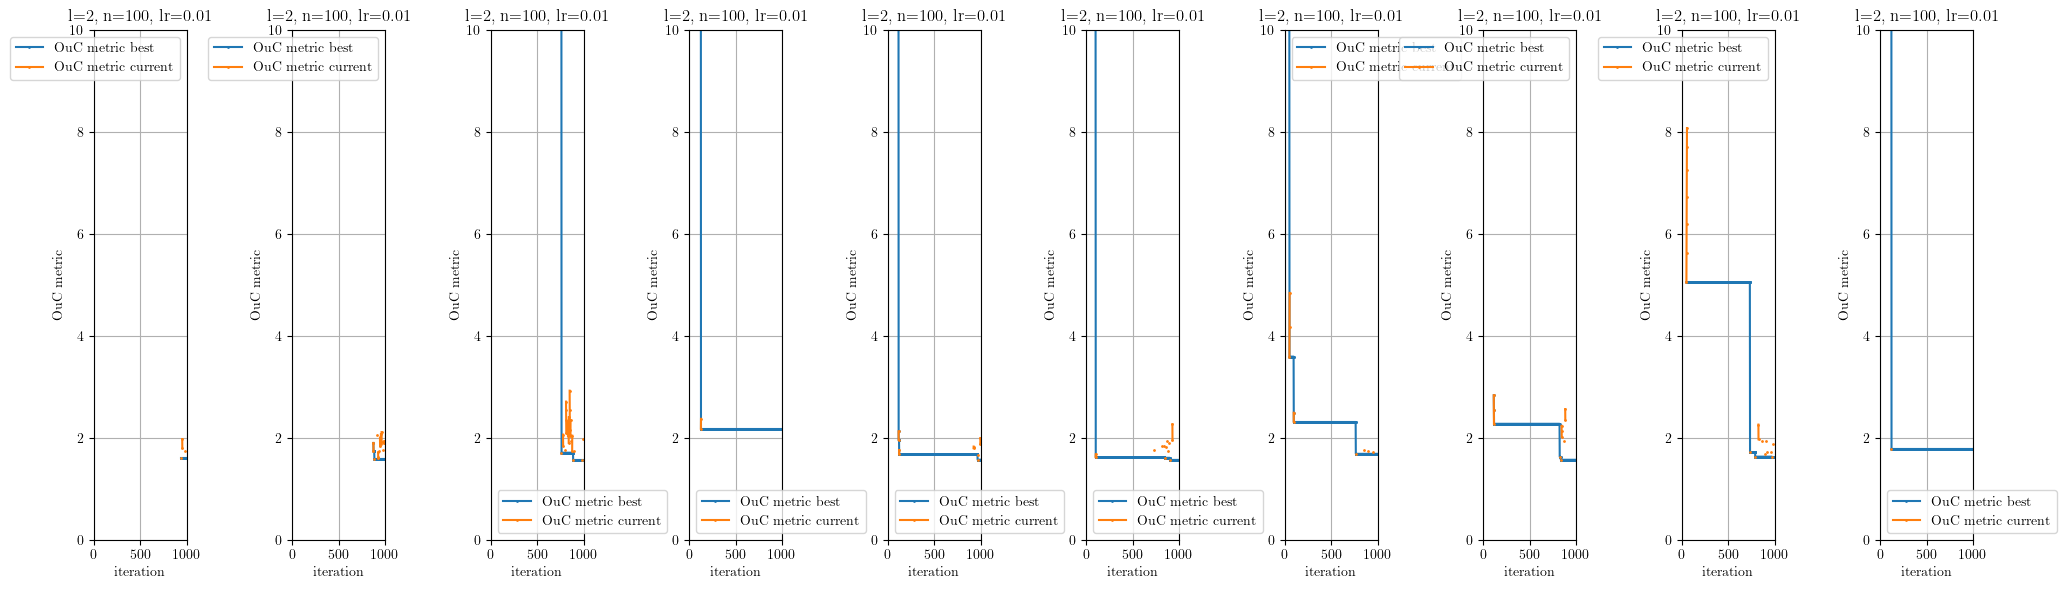

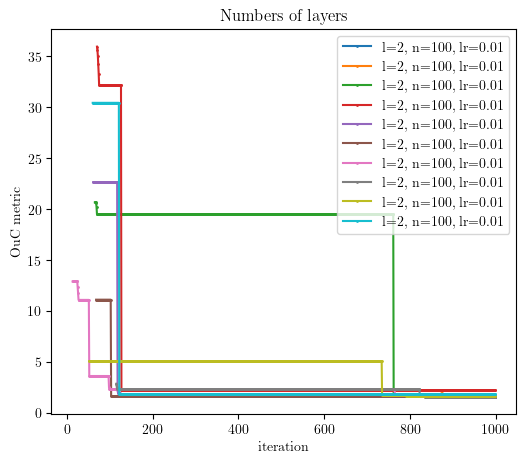

In [18]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7832271 MSE solution: 0.02555340516406177 ratio: 0.008 time: 99.07333993911743
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.582863 MSE solution: 0.01645036594080074 ratio: 0.007 time: 99.32059025764465
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6596631 MSE solution: 0.003173825313566902 ratio: 0.021 time: 104.28161883354187
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0452778 MSE solution: 0.04632378714111027 ratio: 0.003 time: 106.62900471687317
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6646996 MSE solution: 0.01302469825129969 ratio: 0.011 time: 110.01852607727051
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7620684 MSE solution: 0.04544023056036025 ratio: 0.008 time: 105.23401975631714
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.4088392 MSE solution: 0.1514886985875915 ratio: 0.004 time: 98.59646201133728
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5730141 MSE solution: 0.0325010837460919 ratio: 0.021 time: 100.60952353477478
LAYERS: 2 NEURONS: 10

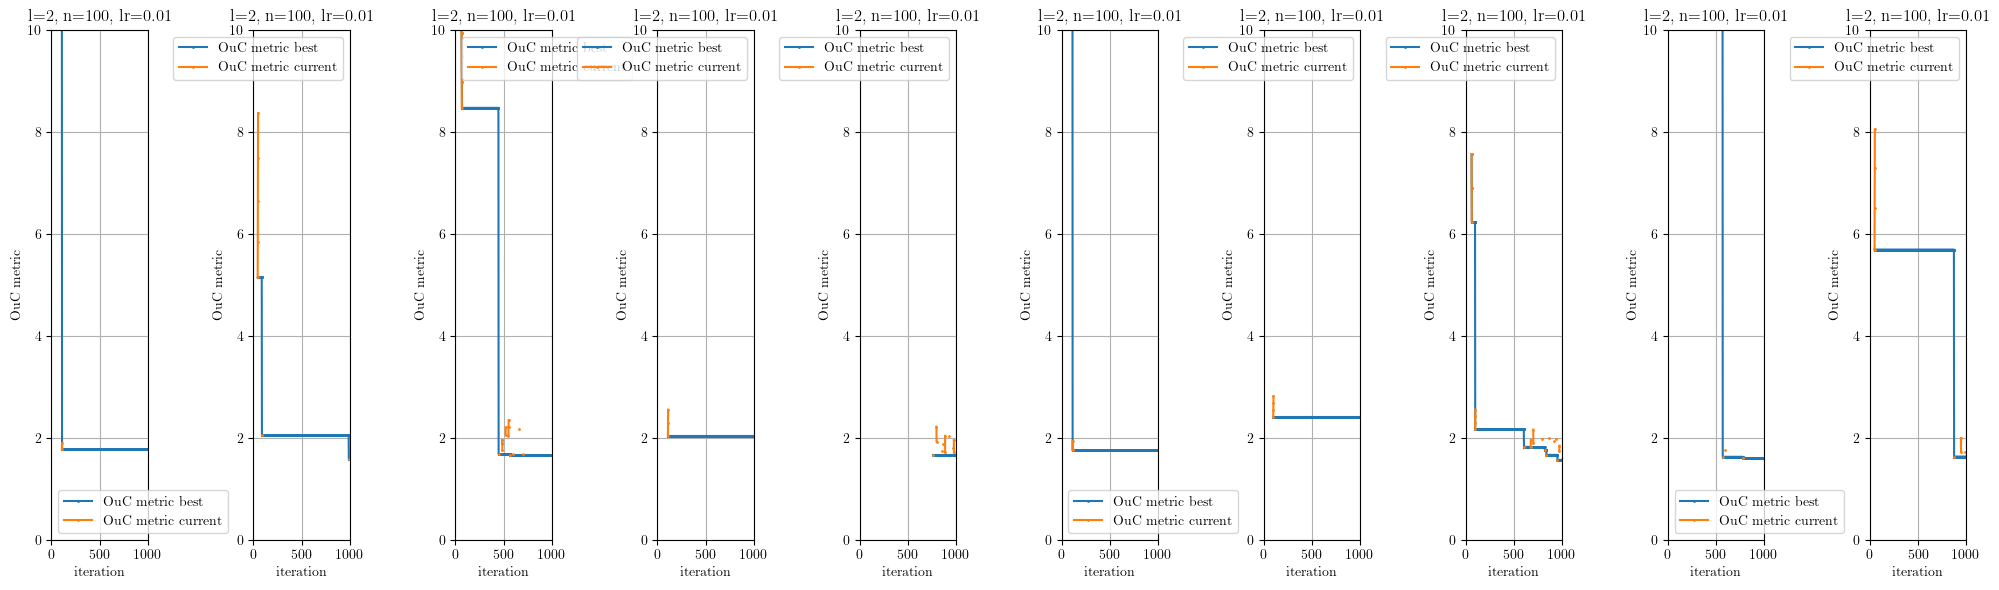

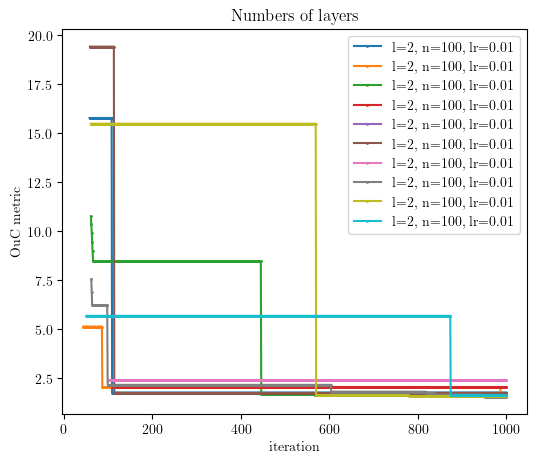

In [19]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5542746 MSE solution: 0.0007591292608637455 ratio: 0.016 time: 99.51658153533936
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 8.629848 MSE solution: 2.0678878867128643 ratio: 0.004 time: 99.68752527236938
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6651118 MSE solution: 0.030897155925089407 ratio: 0.007 time: 95.45947003364563
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6564418 MSE solution: 0.010840894186903476 ratio: 0.012 time: 99.1316351890564
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5358372 MSE solution: 0.008987708685394481 ratio: 0.009 time: 105.73865866661072
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8276215 MSE solution: 0.048376096882250606 ratio: 0.002 time: 101.1496376991272
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.2830913 MSE solution: 0.11482924389462369 ratio: 0.006 time: 101.11115741729736
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7137784 MSE solution: 0.05412829208910904 ratio: 0.001 time: 96.76755595207214
LAYERS: 2 NEURONS: 

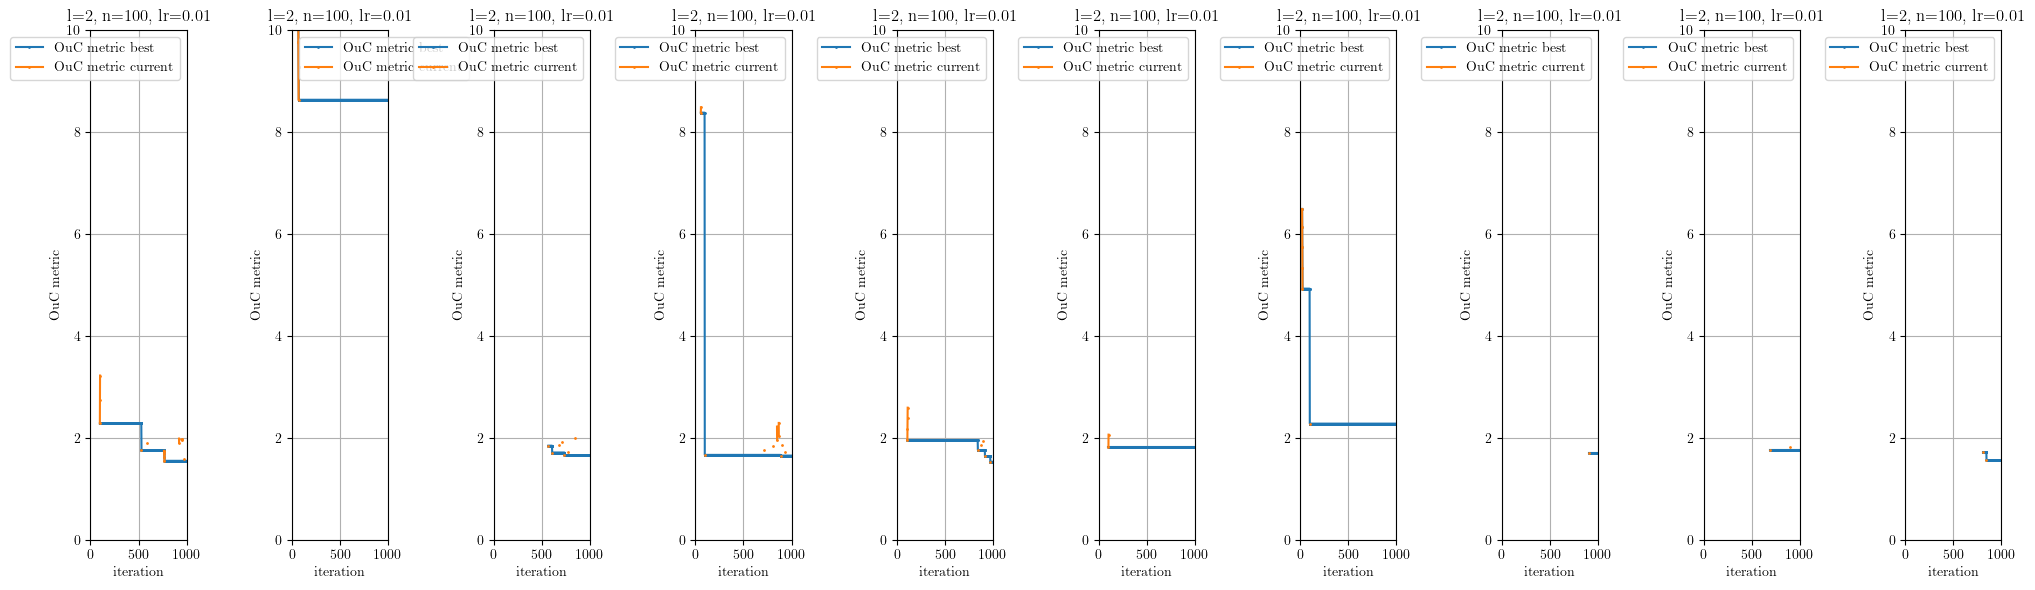

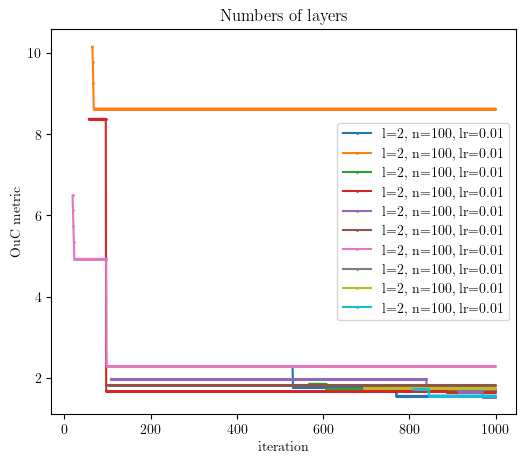

In [20]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 31.98118 MSE solution: 13.392251224546461 ratio: 0.009 time: 97.73977828025818
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7107338 MSE solution: 0.02451981350804758 ratio: 0.004 time: 98.53383898735046
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9215708 MSE solution: 0.08368516892694099 ratio: 0.021 time: 100.4873058795929
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5903034 MSE solution: 0.0028101483733951973 ratio: 0.038 time: 100.23269820213318
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.048365 MSE solution: 0.05048367367284454 ratio: 0.035 time: 105.90585088729858
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6139102 MSE solution: 0.005310974729171531 ratio: 0.009 time: 103.68008804321289
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.912309 MSE solution: 0.060383718364510015 ratio: 0.01 time: 111.12555146217346
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.852018 MSE solution: 0.015421782444371568 ratio: 0.002 time: 112.56036138534546
LAYERS: 2 NEURONS: 1

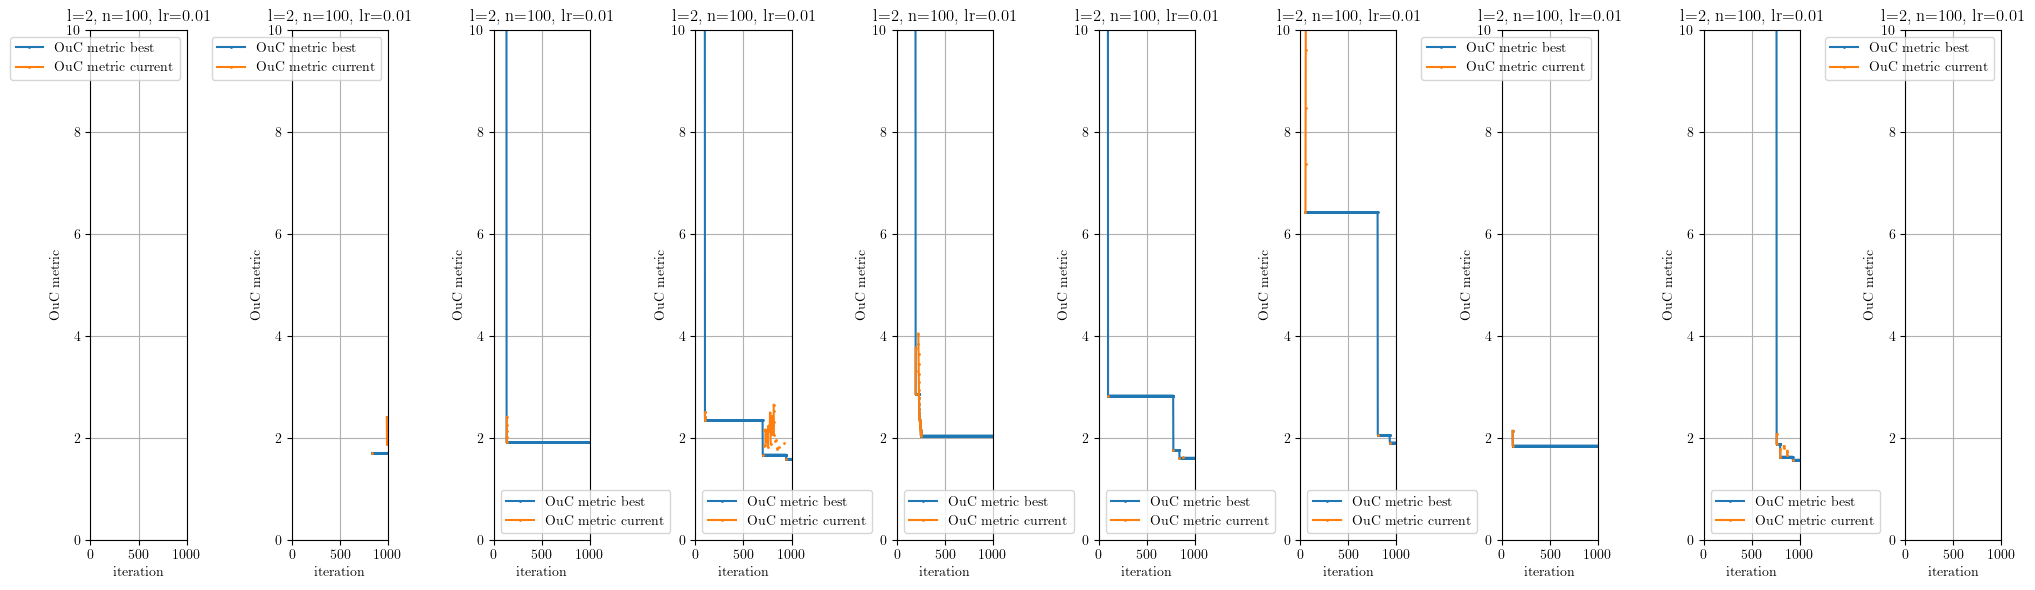

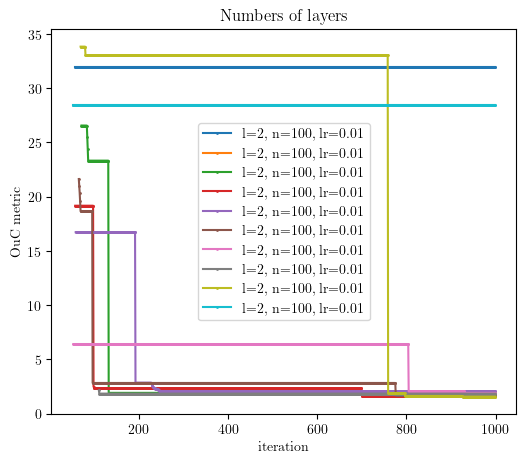

In [21]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5898993 MSE solution: 0.027920903610853365 ratio: 0.025 time: 100.9675862789154
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7105788 MSE solution: 0.020833567783481027 ratio: 0.015 time: 104.20605874061584
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6928763 MSE solution: 0.029379852356218036 ratio: 0.02 time: 97.45891857147217
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 21.689186 MSE solution: 8.07543173009938 ratio: 0.006 time: 104.29990482330322
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6818068 MSE solution: 0.046086565076196906 ratio: 0.008 time: 103.29167580604553
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 32.33514 MSE solution: 13.806134297128892 ratio: 0.002 time: 105.82475256919861
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.1661534 MSE solution: 0.057043520961843286 ratio: 0.005 time: 105.25632905960083
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9988624 MSE solution: 0.03962772088877866 ratio: 0.003 time: 105.80580186843872
LAYERS: 2 NEURONS: 

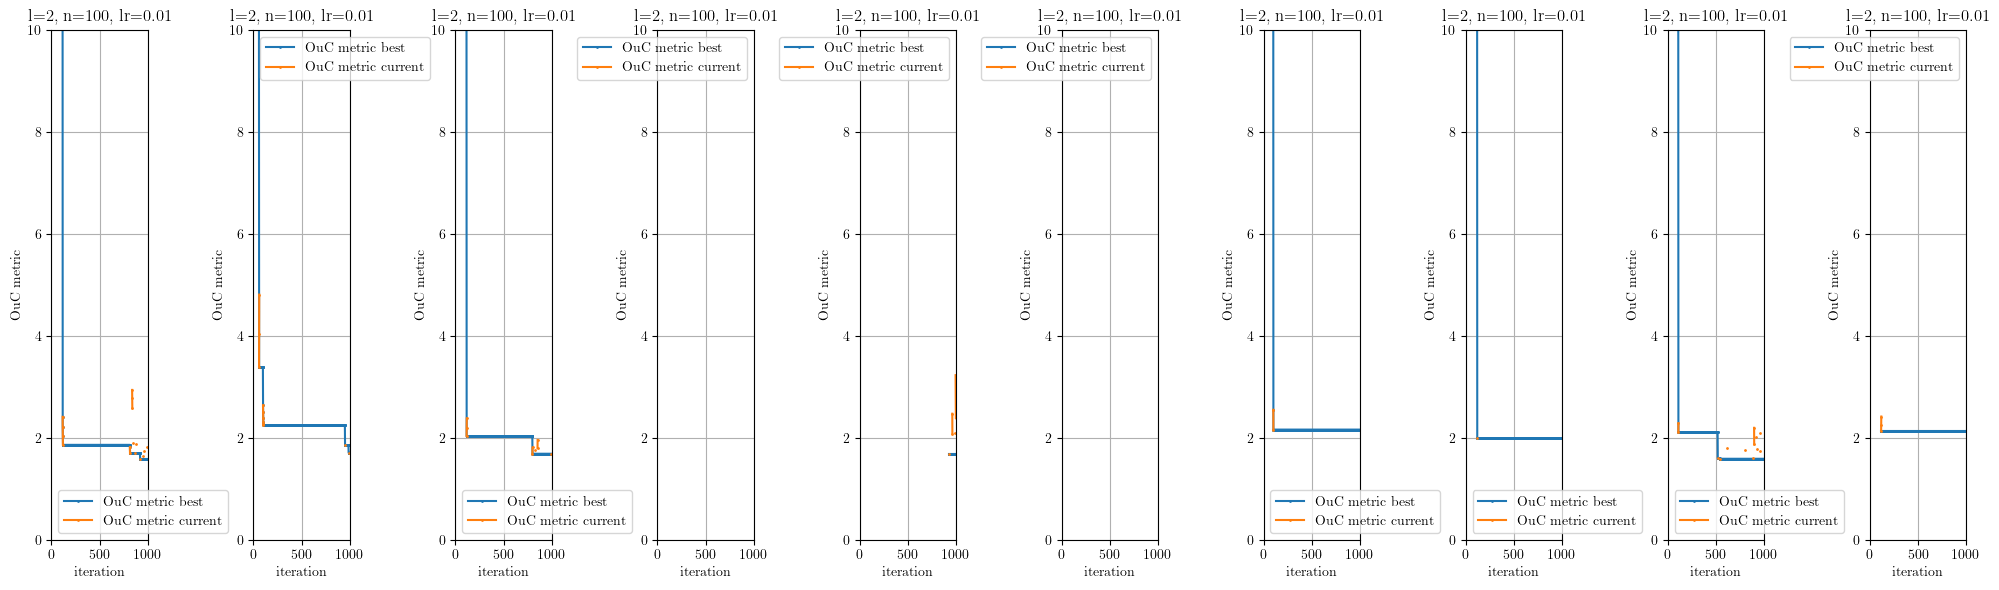

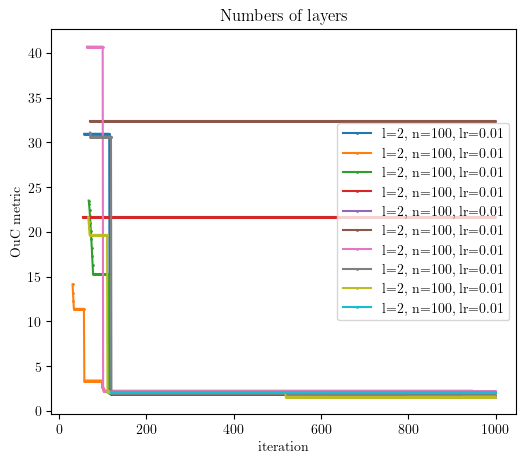

In [22]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 23.13138 MSE solution: 8.785954236125042 ratio: 0.008 time: 101.6649899482727
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0653198 MSE solution: 0.09106091429242331 ratio: 0.002 time: 106.59205961227417
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 25.645105 MSE solution: 10.360905169613831 ratio: 0.004 time: 104.33079743385315
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6883597 MSE solution: 0.048814866502125825 ratio: 0.025 time: 93.88267087936401
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.77407752485959 ratio: 0.0 time: 101.82655143737793
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7281208 MSE solution: 0.02430730993534518 ratio: 0.009 time: 90.849289894104
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 36.67684 MSE solution: 17.94150301056923 ratio: 0.014 time: 97.08681774139404
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6200726 MSE solution: 0.0029608428523657734 ratio: 0.019 time: 98.82668447494507
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilo

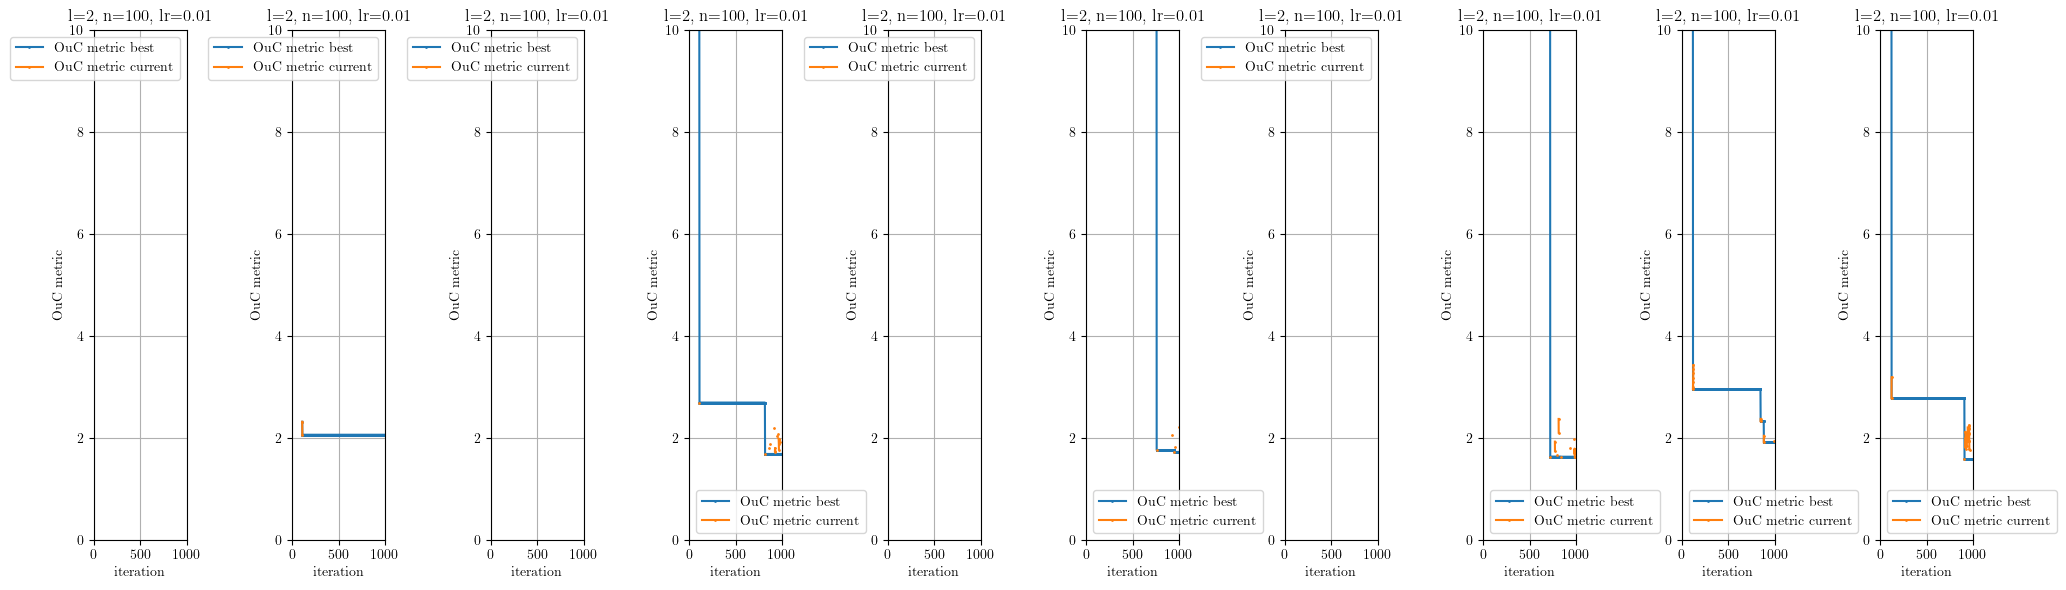

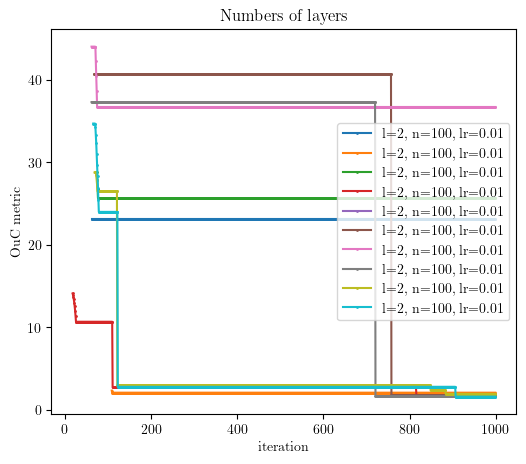

In [23]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0860507 MSE solution: 0.09061381891421234 ratio: 0.017 time: 110.51335573196411
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6636126 MSE solution: 0.01699818852915273 ratio: 0.017 time: 100.13847470283508
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 27.999285 MSE solution: 11.285639590884111 ratio: 0.01 time: 95.32343435287476
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.017603 MSE solution: 0.050227563005067366 ratio: 0.016 time: 99.3371114730835
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5379368 MSE solution: 0.00048118559327661026 ratio: 0.021 time: 103.46442604064941
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6041524 MSE solution: 0.0073811423842557395 ratio: 0.006 time: 105.51491713523865
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7293637 MSE solution: 0.012565830680566534 ratio: 0.011 time: 104.185227394104
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5634314 MSE solution: 0.014588567957065009 ratio: 0.019 time: 101.19592022895813
LAYERS: 2 NEURON

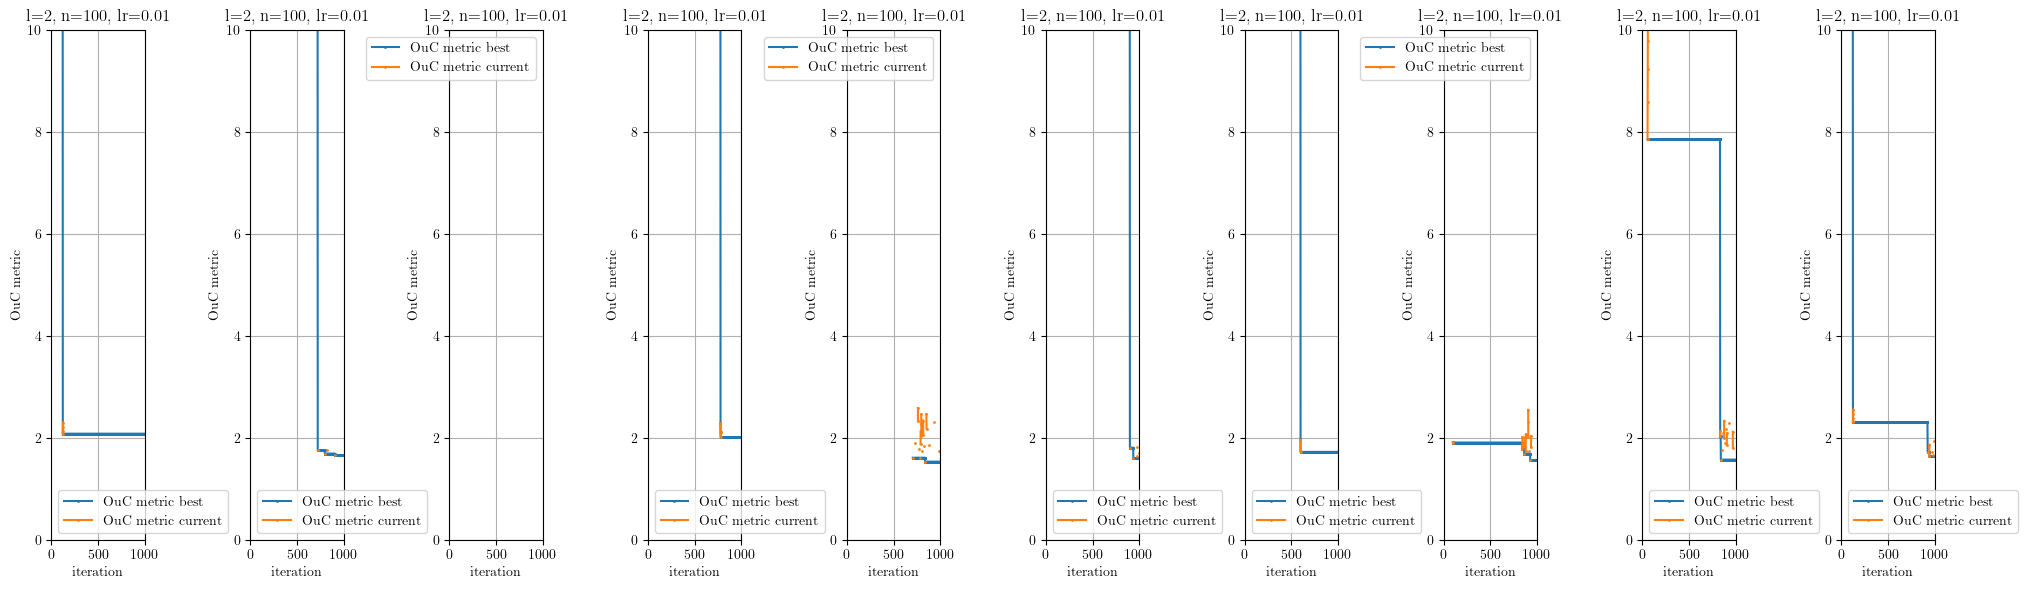

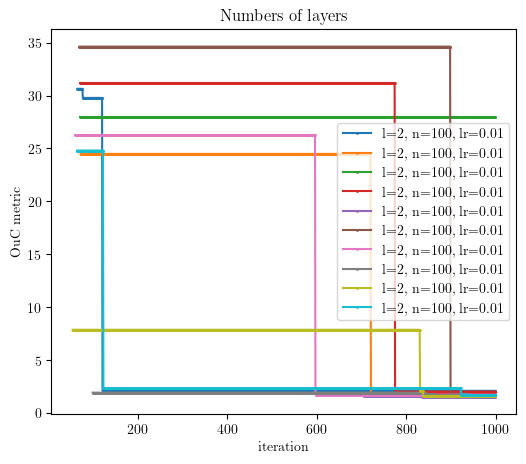

In [24]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6913146 MSE solution: 0.028366505474503454 ratio: 0.015 time: 112.19119358062744
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.9794784 MSE solution: 0.738685800755723 ratio: 0.019 time: 102.21407580375671
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9782667 MSE solution: 0.03929649943228986 ratio: 0.003 time: 100.88944983482361
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.825232 MSE solution: 0.054052171437487424 ratio: 0.005 time: 108.33072829246521
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6462595 MSE solution: 0.002210009850560741 ratio: 0.035 time: 107.84720134735107
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 24.723455 MSE solution: 10.74999585022563 ratio: 0.014 time: 109.30493497848511
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8445529 MSE solution: 0.05409583205916931 ratio: 0.018 time: 103.35259413719177
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 33.668236 MSE solution: 14.341184571124565 ratio: 0.005 time: 104.82546734809875
LAYERS: 2 NEURONS: 

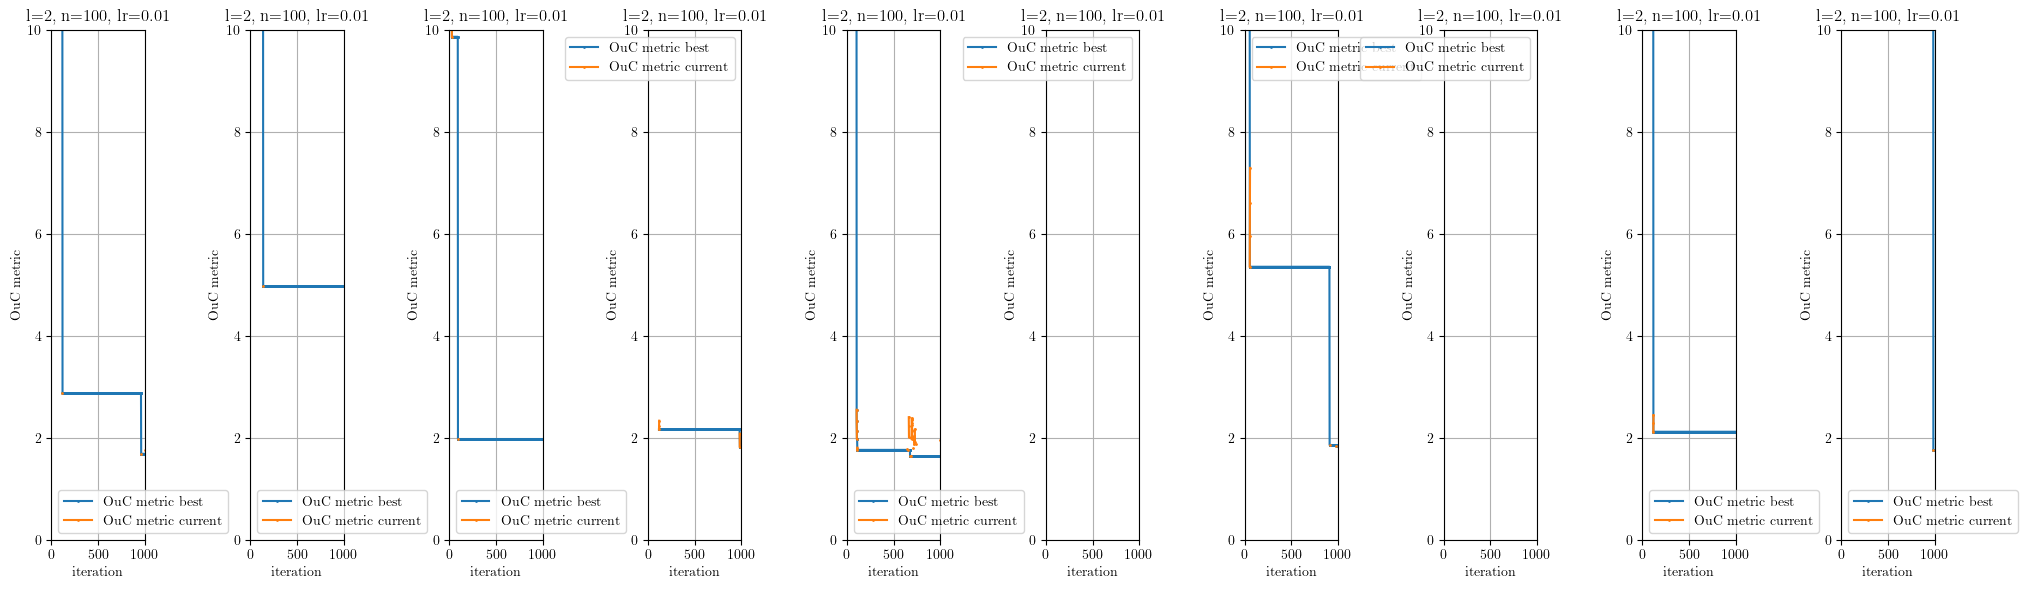

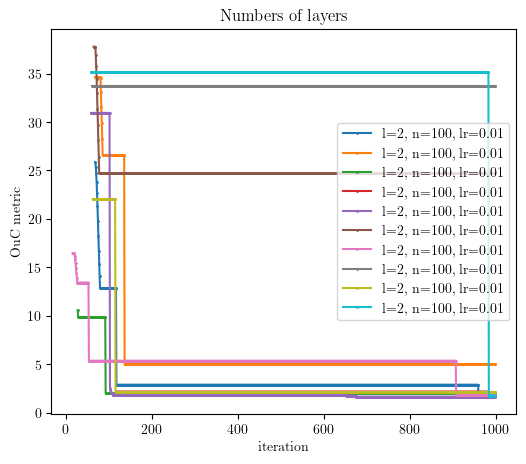

In [25]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6704866 MSE solution: 0.014586821312712982 ratio: 0.014 time: 100.47708082199097
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7322812 MSE solution: 0.06075326701399888 ratio: 0.002 time: 100.55342364311218
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0106816 MSE solution: 0.08918453605475446 ratio: 0.006 time: 102.63233876228333
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6414291 MSE solution: 0.019414556558824198 ratio: 0.01 time: 103.6302011013031
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.4741467830140902 ratio: 0.0 time: 101.12823724746704
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 17.921535 MSE solution: 6.969549485703477 ratio: 0.012 time: 103.36741709709167
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 18.32395 MSE solution: 6.636884423181443 ratio: 0.003 time: 101.22238683700562
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6297716 MSE solution: 0.002465015780986519 ratio: 0.009 time: 104.90851283073425
LAYERS: 2 NEURONS: 100 LR: 0.

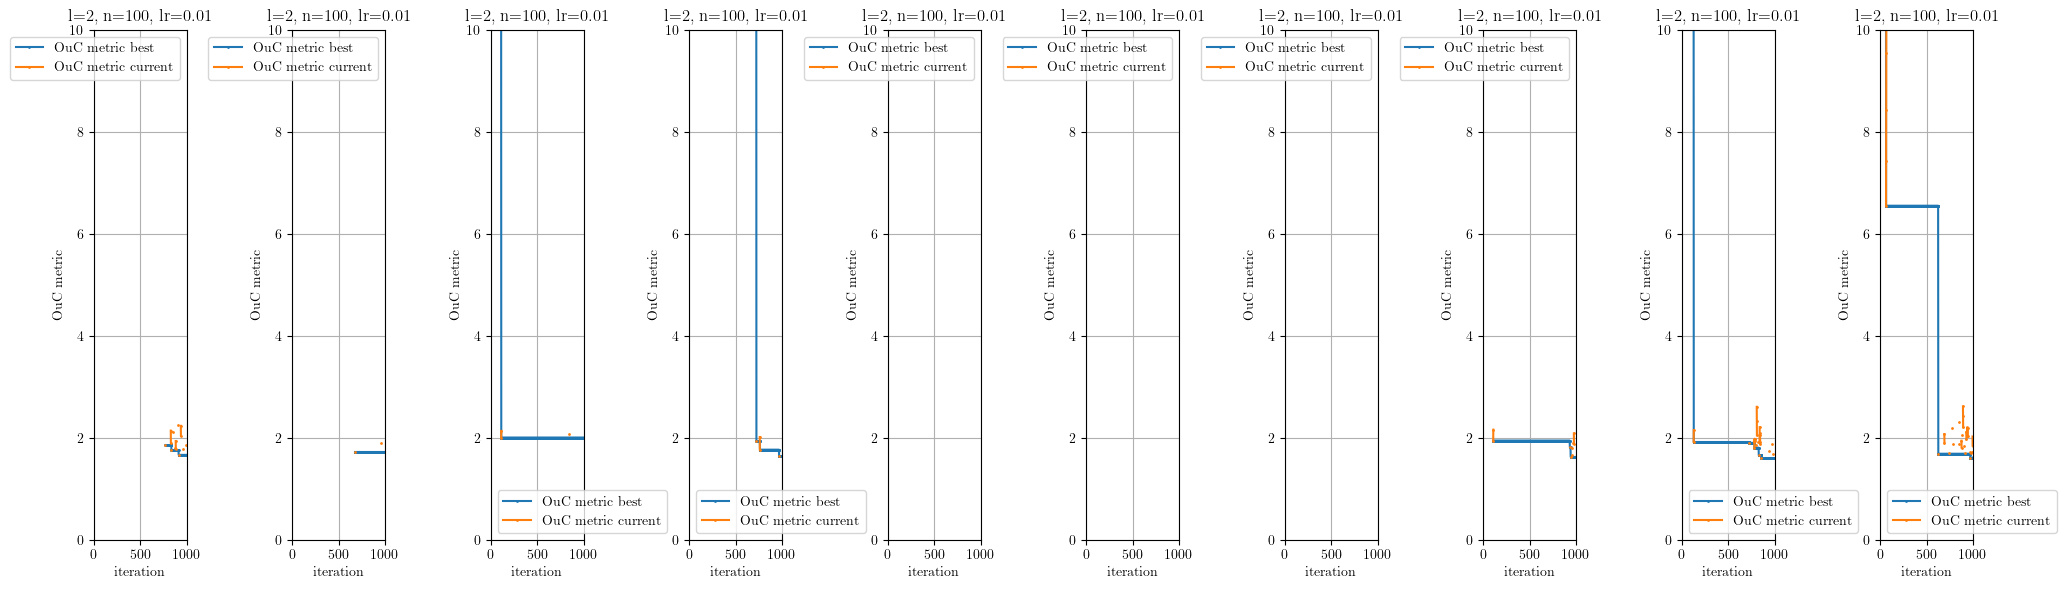

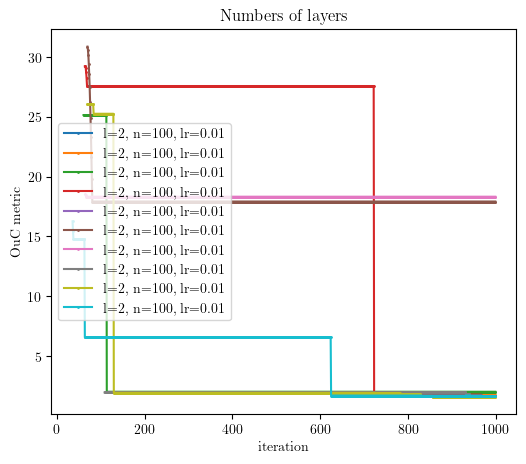

In [26]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.584037 MSE solution: 0.00574890536163612 ratio: 0.004 time: 115.23060011863708
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6542344 MSE solution: 0.03021363363142145 ratio: 0.005 time: 96.41714596748352
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.597134 MSE solution: 0.1512808233411377 ratio: 0.018 time: 90.36238026618958
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9720004 MSE solution: 0.02268944867600414 ratio: 0.002 time: 92.65852642059326
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8109348 MSE solution: 0.04169825239165093 ratio: 0.008 time: 90.39533472061157
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.72855 MSE solution: 0.04069793618840444 ratio: 0.006 time: 85.58156704902649
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8201044 MSE solution: 0.029754974786986008 ratio: 0.002 time: 90.16128253936768
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6172986 MSE solution: 0.007878836573583806 ratio: 0.017 time: 88.22677707672119
LAYERS: 2 NEURONS: 100 LR:

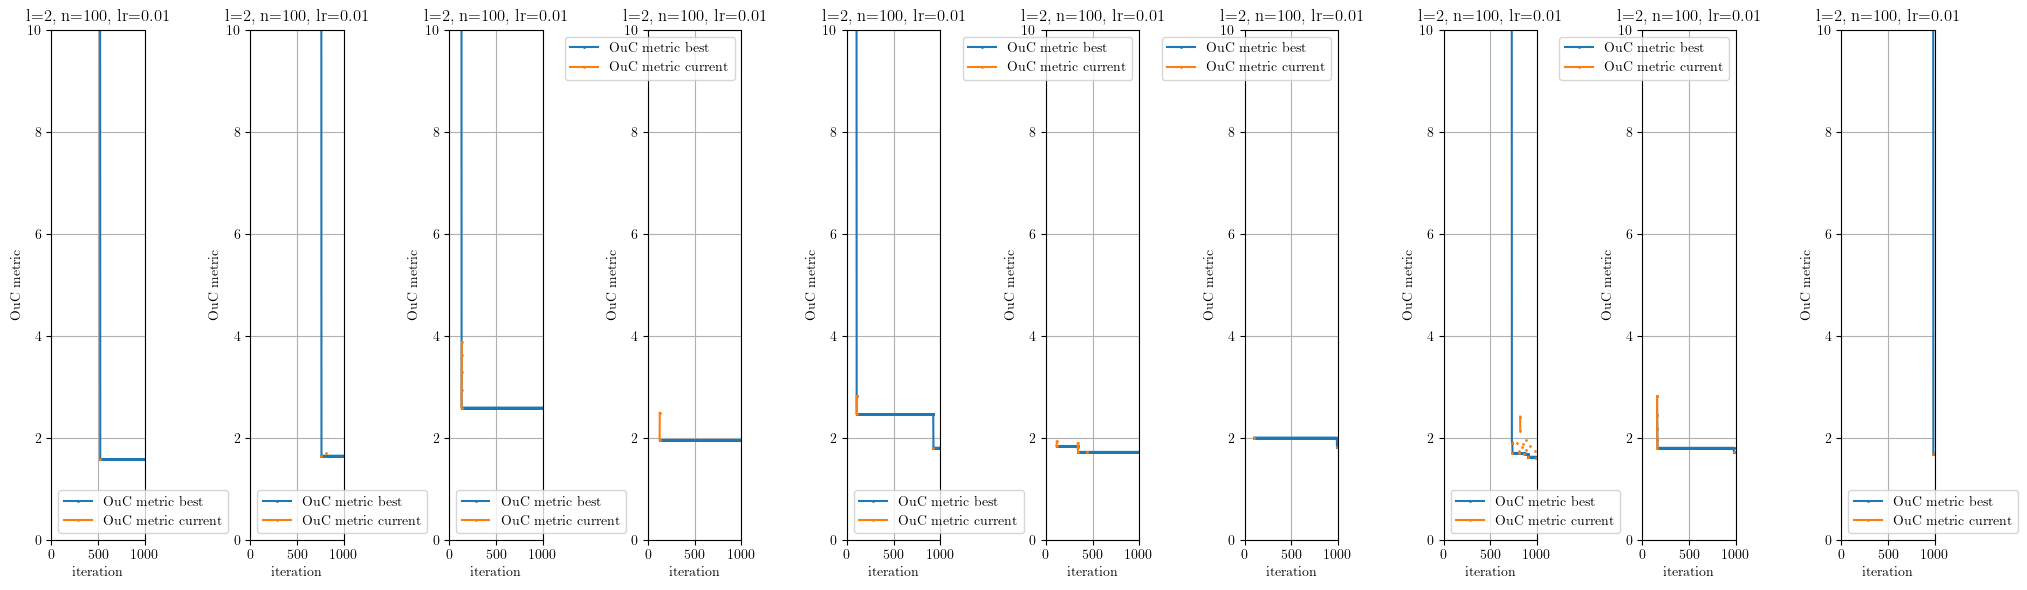

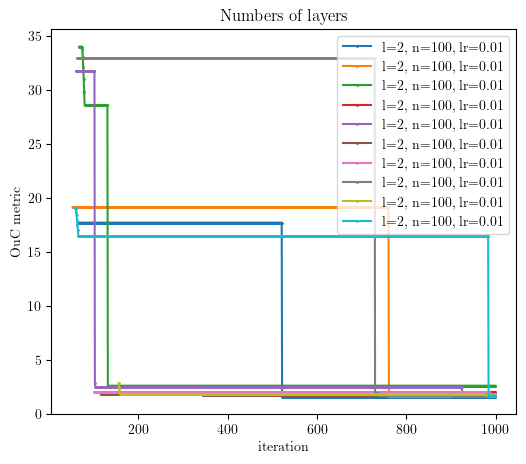

In [27]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9548514 MSE solution: 0.036915623708624064 ratio: 0.019 time: 98.58338952064514
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6088241 MSE solution: 0.031367773303636444 ratio: 0.004 time: 99.53188467025757
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.732336 MSE solution: 0.008821815520807642 ratio: 0.005 time: 99.21420884132385
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 0.8177785491767816 ratio: 0.0 time: 97.77363514900208
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7899476 MSE solution: 0.03473070431999147 ratio: 0.005 time: 97.02671122550964
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.588345 MSE solution: 0.011772145859239502 ratio: 0.004 time: 97.41397500038147
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6371343 MSE solution: 0.02037342397942672 ratio: 0.02 time: 99.11955046653748
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8197659 MSE solution: 0.014384229997002057 ratio: 0.018 time: 98.039053440094
LAYERS: 2 NEURONS: 100 LR: 0.01 e

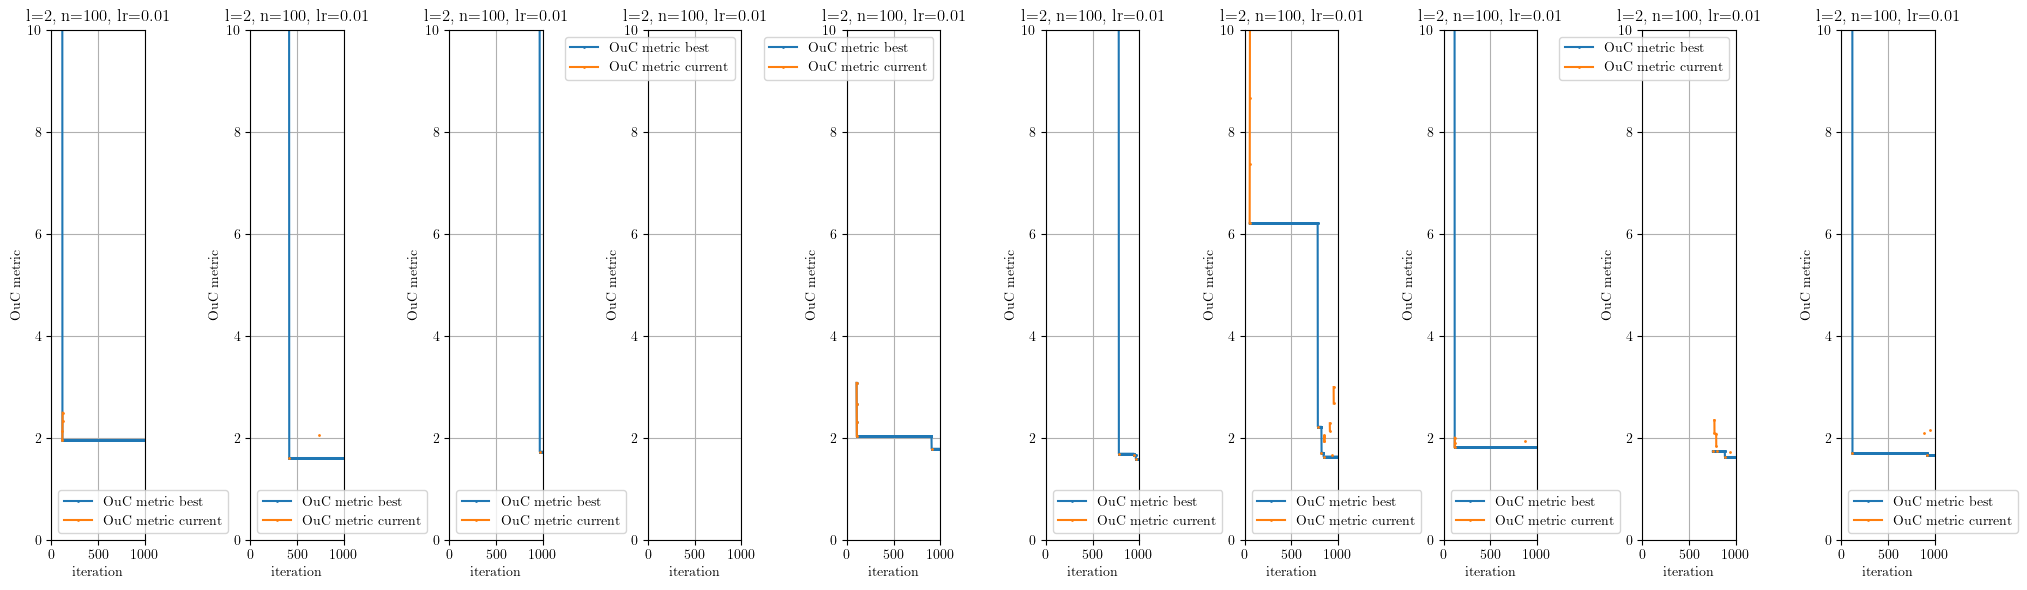

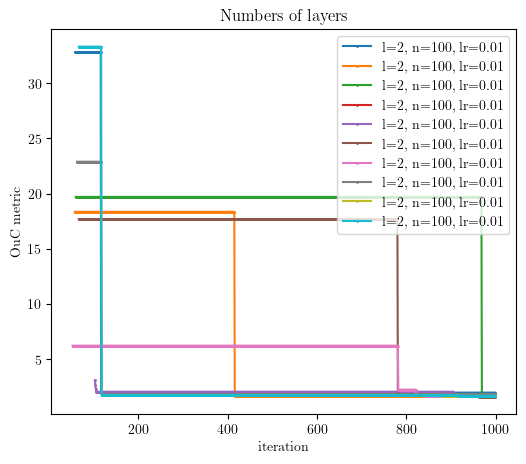

In [28]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0208685 MSE solution: 0.027232260796652568 ratio: 0.008 time: 99.33268237113953
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6961459 MSE solution: 0.03791223218946104 ratio: 0.02 time: 98.72119092941284
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8357896 MSE solution: 0.0316881705449931 ratio: 0.034 time: 99.33194994926453
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5655141 MSE solution: 0.001298938837328062 ratio: 0.014 time: 98.99956464767456
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5609053 MSE solution: 0.004553263483630361 ratio: 0.054 time: 100.24533295631409
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5462089 MSE solution: 0.00033267617389816465 ratio: 0.025 time: 99.69647717475891
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 31.085453 MSE solution: 12.895731702509686 ratio: 0.012 time: 99.0374174118042
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6608295 MSE solution: 0.00410683410559158 ratio: 0.018 time: 97.96818733215332
LAYERS: 2 NEURONS: 10

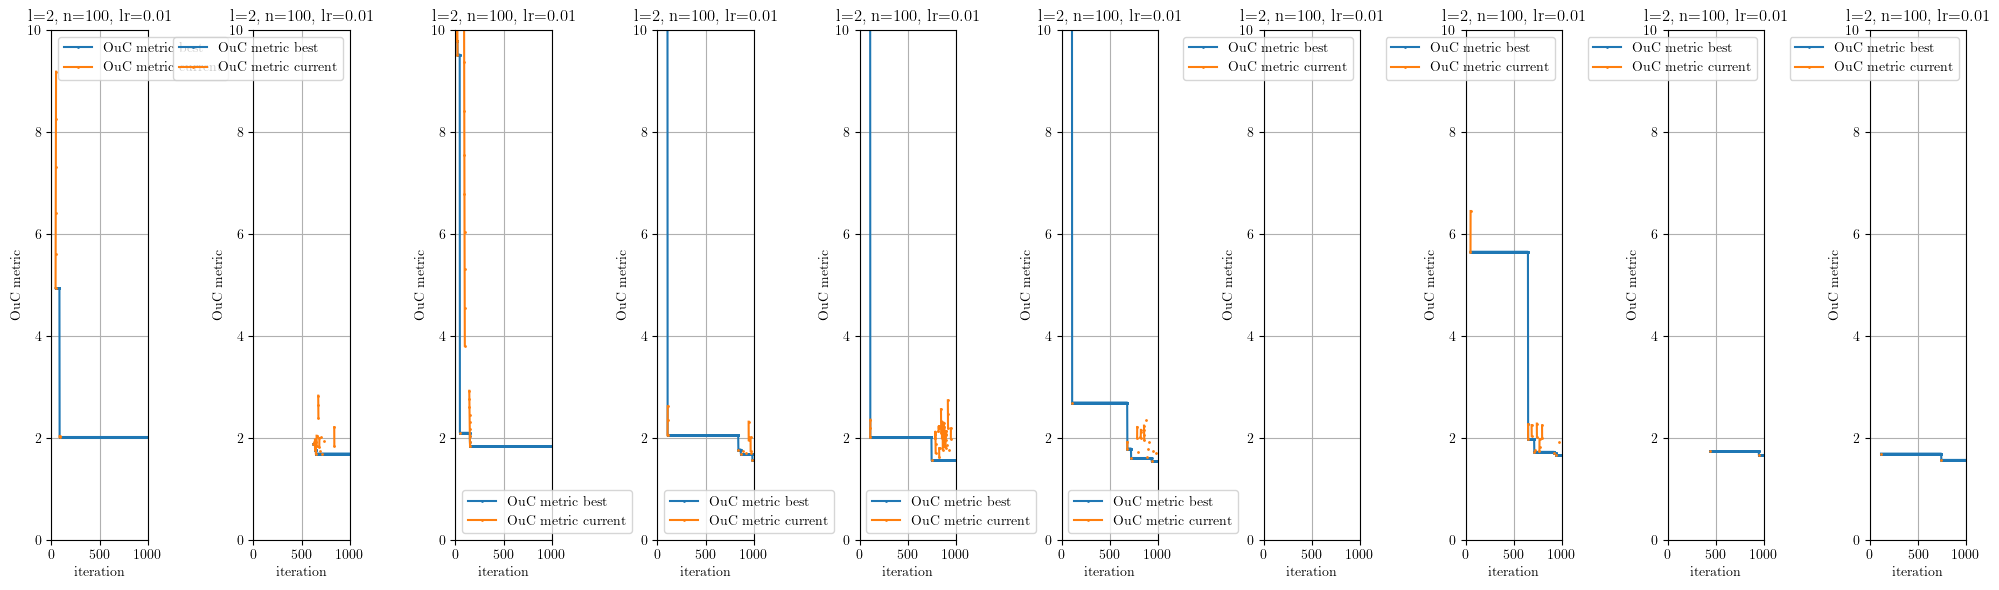

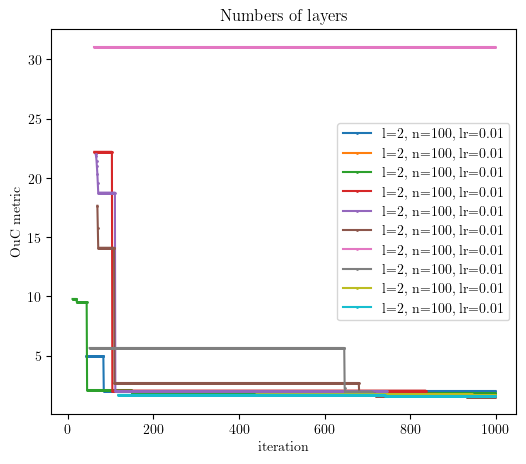

In [29]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 29.753014 MSE solution: 12.416837855200844 ratio: 0.002 time: 99.26475882530212
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 7.582556 MSE solution: 2.238824939238862 ratio: 0.011 time: 101.12423157691956
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.3682837 MSE solution: 0.6875466851615087 ratio: 0.006 time: 95.98208141326904
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.678196 MSE solution: 0.028739208943846798 ratio: 0.026 time: 98.43099474906921
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5795836 MSE solution: 0.0006677466283965785 ratio: 0.032 time: 98.28776240348816
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6037495 MSE solution: 0.012041620890350628 ratio: 0.02 time: 100.19281435012817
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 27.319832 MSE solution: 11.240669877802887 ratio: 0.001 time: 102.87443113327026
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9307138 MSE solution: 0.05079309399111539 ratio: 0.006 time: 96.68359088897705
LAYERS: 2 NEURONS: 100 LR

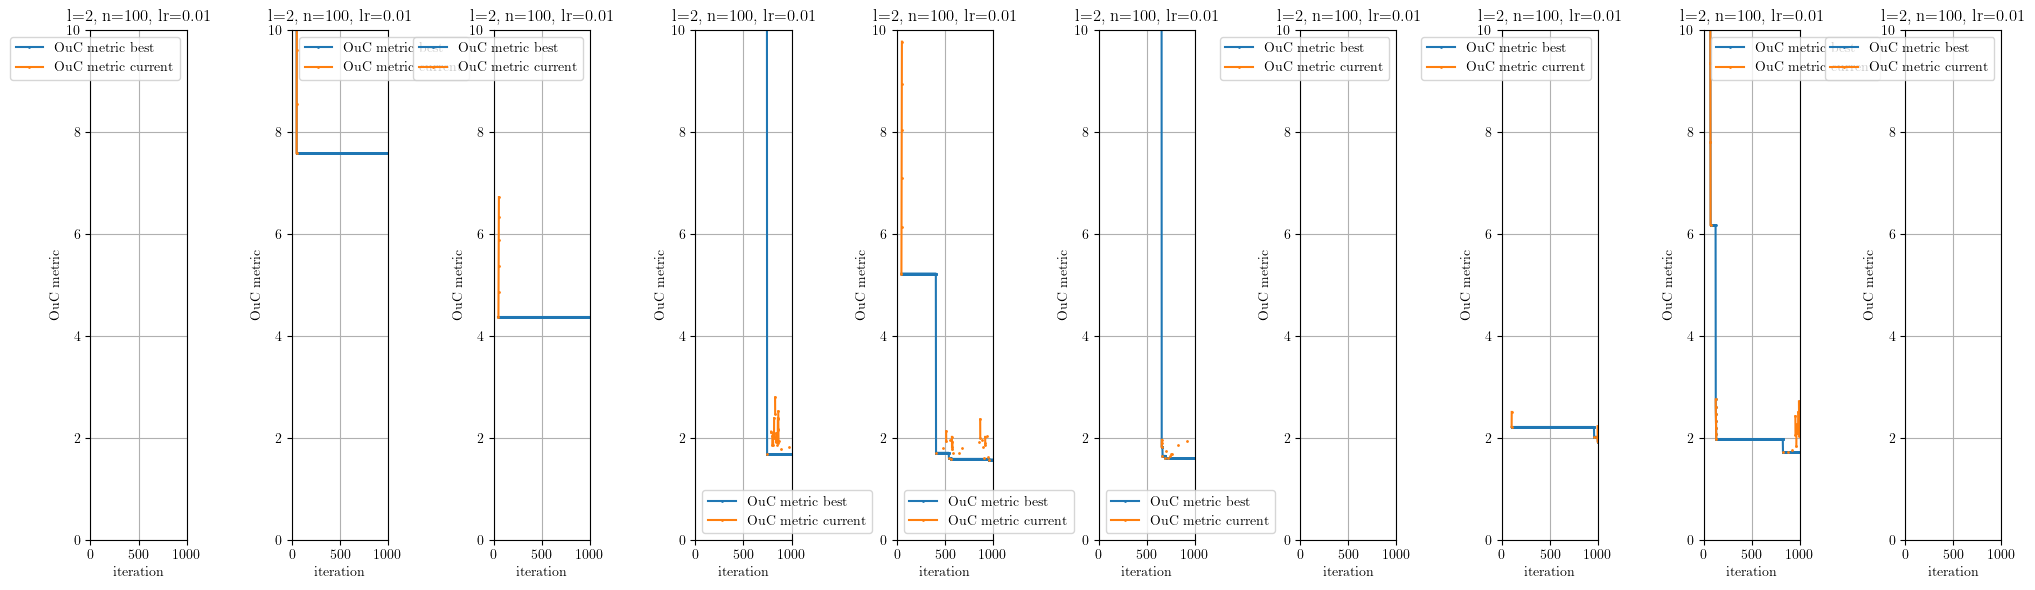

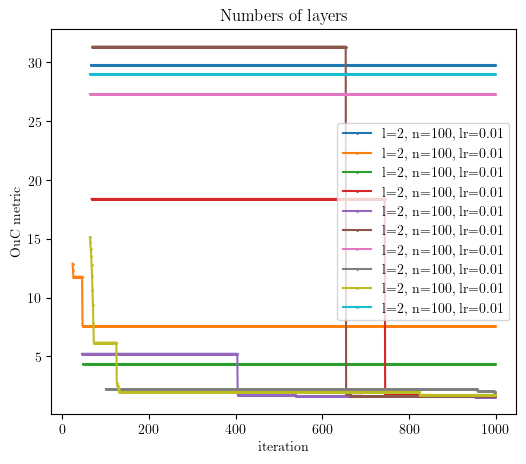

In [30]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6328906 MSE solution: 0.015531148073564661 ratio: 0.001 time: 91.47590637207031
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0083745 MSE solution: 0.044363088985549505 ratio: 0.009 time: 90.44227147102356
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6763171 MSE solution: 0.04359807766608534 ratio: 0.002 time: 91.22814440727234
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7826684 MSE solution: 0.014442588958101764 ratio: 0.006 time: 97.21684741973877
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9797478 MSE solution: 0.08720070278169419 ratio: 0.001 time: 91.52329277992249
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.65389 MSE solution: 0.0246732278885472 ratio: 0.021 time: 103.13531827926636
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6537019 MSE solution: 0.003720465097406108 ratio: 0.008 time: 106.06689977645874
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6078514 MSE solution: 0.020269246900926505 ratio: 0.005 time: 106.0588858127594
LAYERS: 2 NEURONS: 1

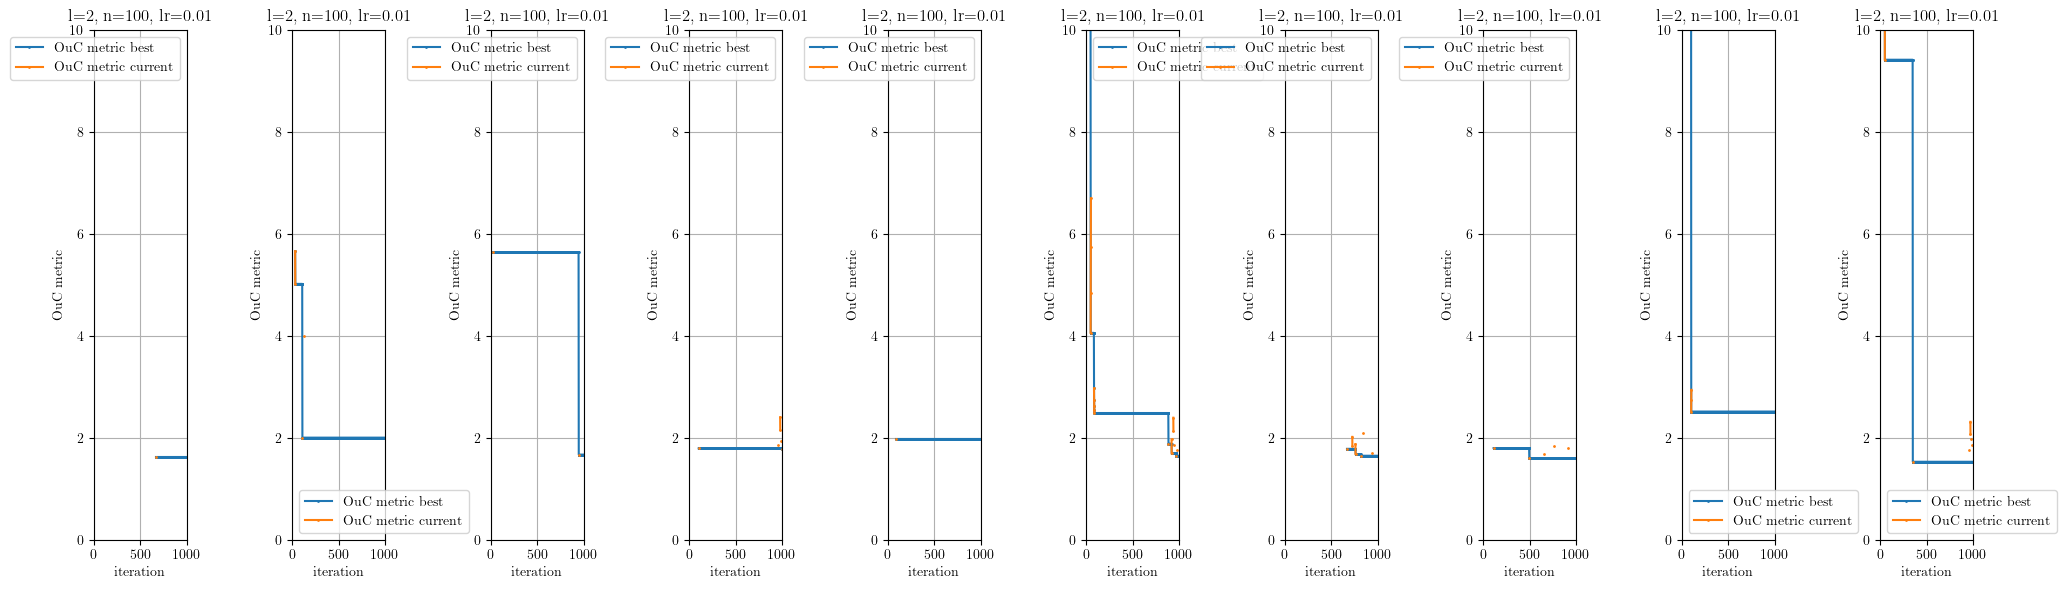

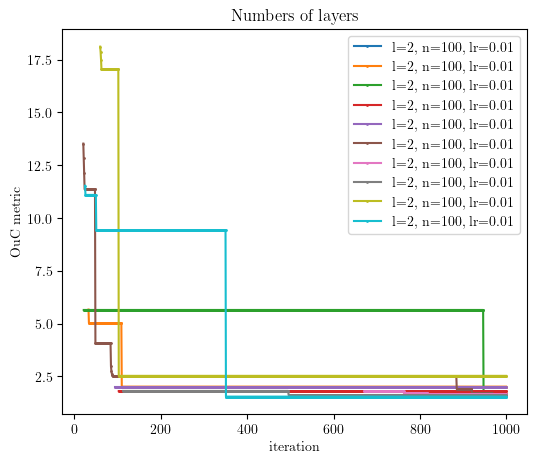

In [31]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6121311 MSE solution: 0.0017005574269022888 ratio: 0.025 time: 106.83861017227173
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5482326 MSE solution: 0.00024372237888257436 ratio: 0.029 time: 106.78048801422119
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9144274 MSE solution: 0.0660163433561448 ratio: 0.018 time: 103.77353882789612
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7002313 MSE solution: 0.006693620789147086 ratio: 0.018 time: 104.4628632068634
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.622605405530125 ratio: 0.0 time: 102.40231537818909
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5713502 MSE solution: 0.01960984460040171 ratio: 0.018 time: 108.07621765136719
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6492059 MSE solution: 0.022016555339495415 ratio: 0.009 time: 109.41426825523376
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.680218 MSE solution: 0.00990105681744661 ratio: 0.01 time: 108.0121259689331
LAYERS: 2 NEURONS: 100 L

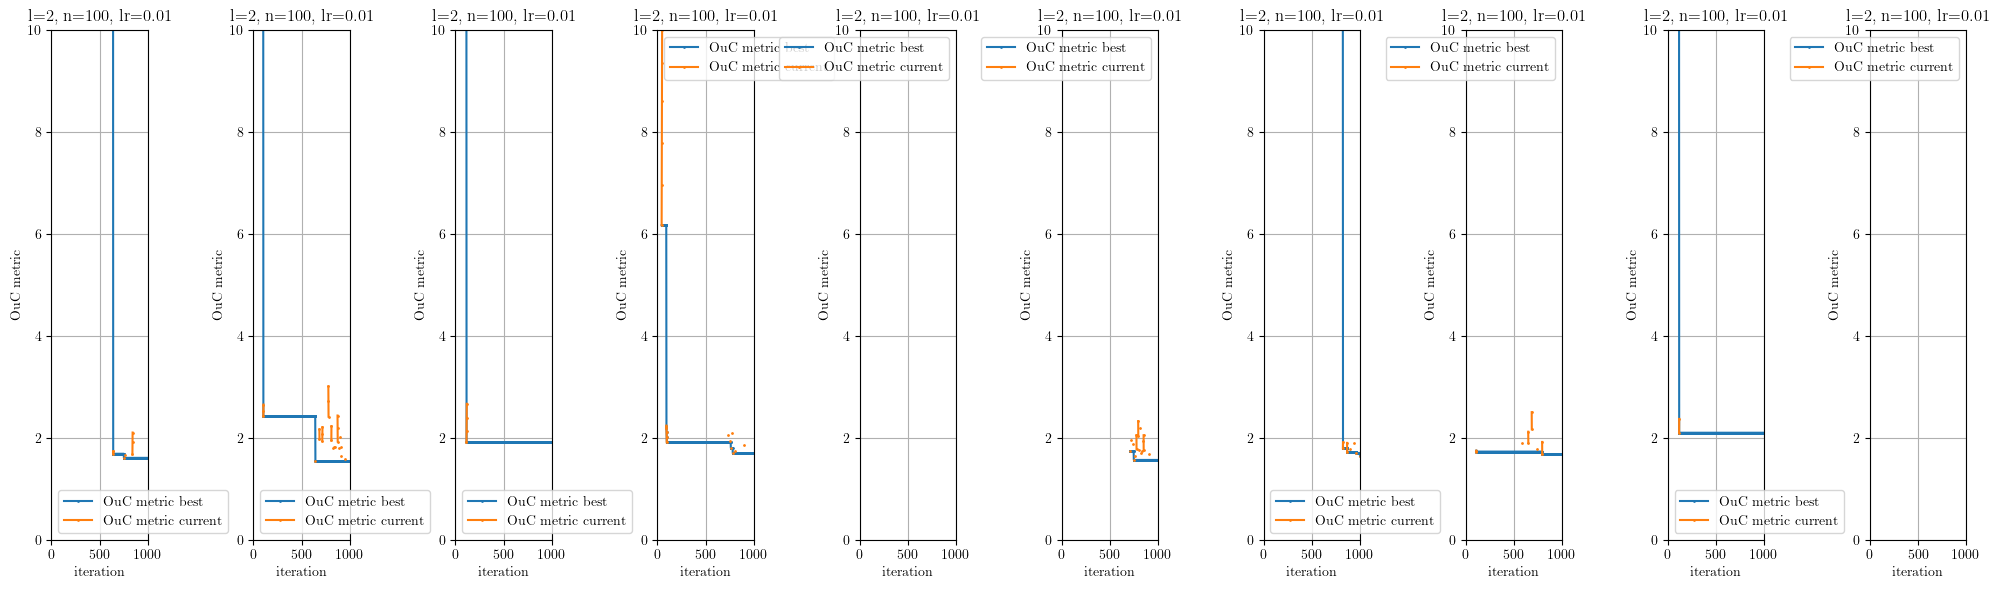

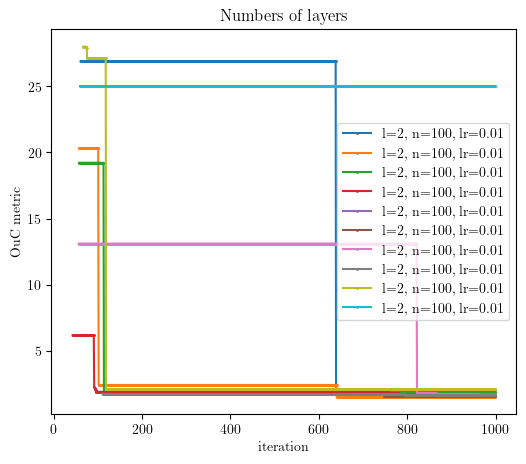

In [32]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6122748 MSE solution: 0.00433796185947181 ratio: 0.013 time: 104.44192028045654
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6239017 MSE solution: 0.02530529290214725 ratio: 0.011 time: 105.75475287437439
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0031083 MSE solution: 0.07244750061649605 ratio: 0.005 time: 105.37117624282837
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5713857 MSE solution: 0.022064181504435083 ratio: 0.021 time: 103.78503894805908
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.691794 MSE solution: 0.029957469595585085 ratio: 0.004 time: 104.19079828262329
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5806164 MSE solution: 0.008339191236392039 ratio: 0.008 time: 103.70440340042114
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6614732 MSE solution: 0.03394143618420451 ratio: 0.016 time: 105.6842908859253
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5778013 MSE solution: 0.012903883156104516 ratio: 0.026 time: 102.2161340713501
LAYERS: 2 NEURO

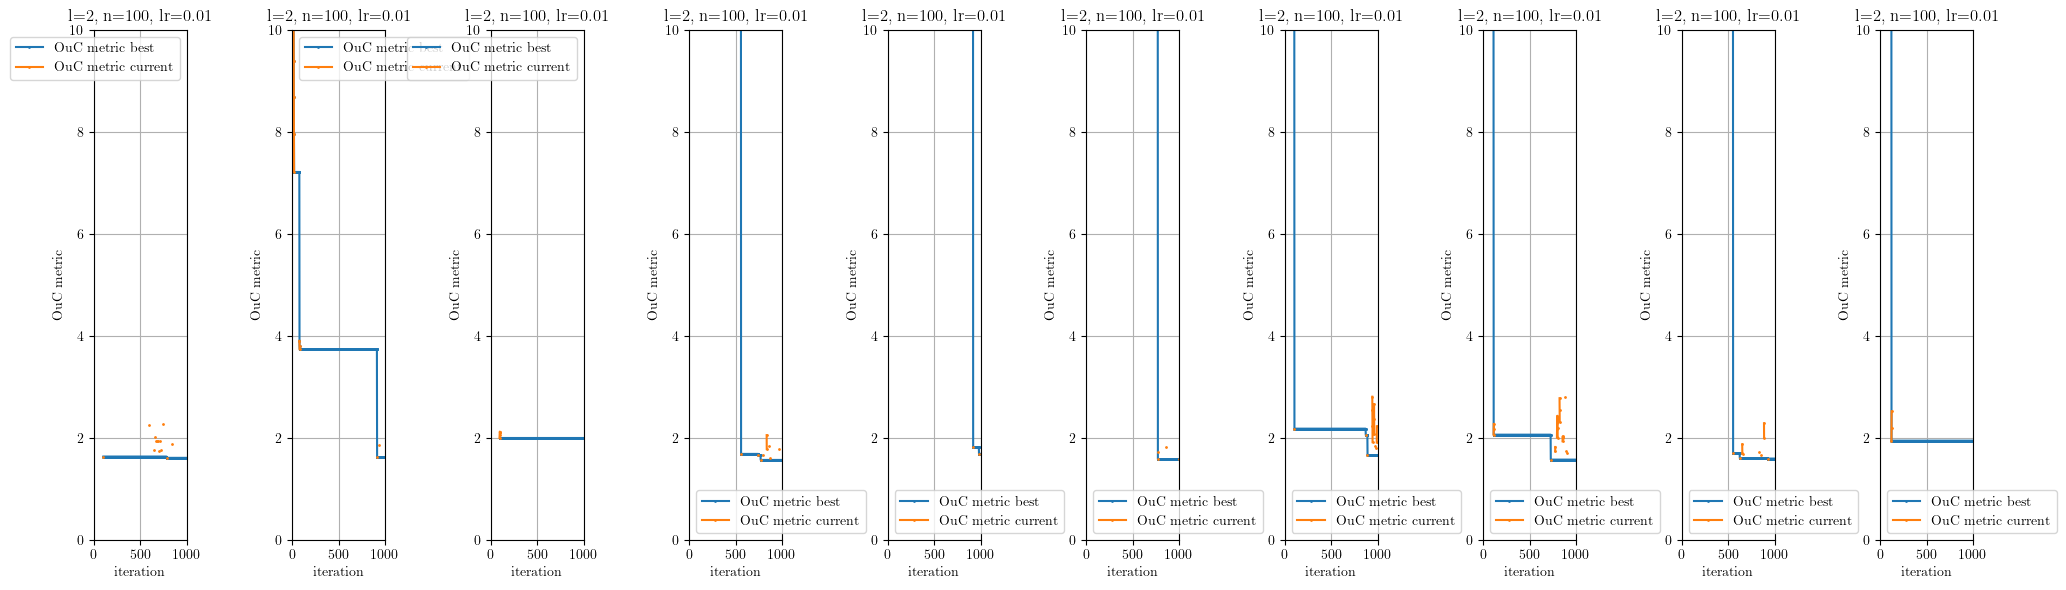

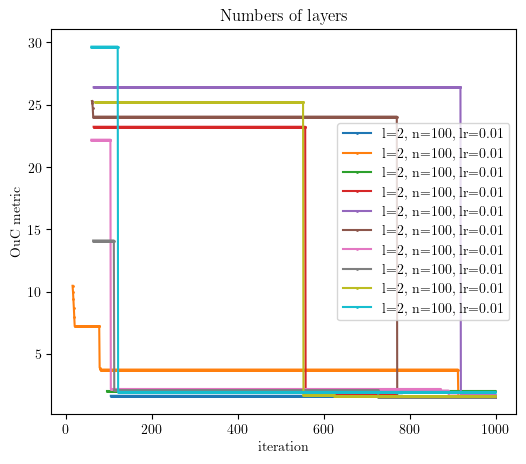

In [33]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6102986 MSE solution: 0.004587117403845234 ratio: 0.022 time: 105.27707886695862
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7134855 MSE solution: 0.01970052932277562 ratio: 0.007 time: 106.2847969532013
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6250969 MSE solution: 0.001901381883468351 ratio: 0.005 time: 106.09515166282654
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5967798 MSE solution: 0.014381134756290345 ratio: 0.016 time: 104.79641318321228
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6095252 MSE solution: 0.023120791848108817 ratio: 0.018 time: 105.5984902381897
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6652645 MSE solution: 0.02776127450869567 ratio: 0.011 time: 105.54661703109741
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8652965 MSE solution: 0.05571994479834965 ratio: 0.026 time: 102.93091034889221
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7203788 MSE solution: 0.01913475594428535 ratio: 0.004 time: 104.69937634468079
LAYERS: 2 NEUR

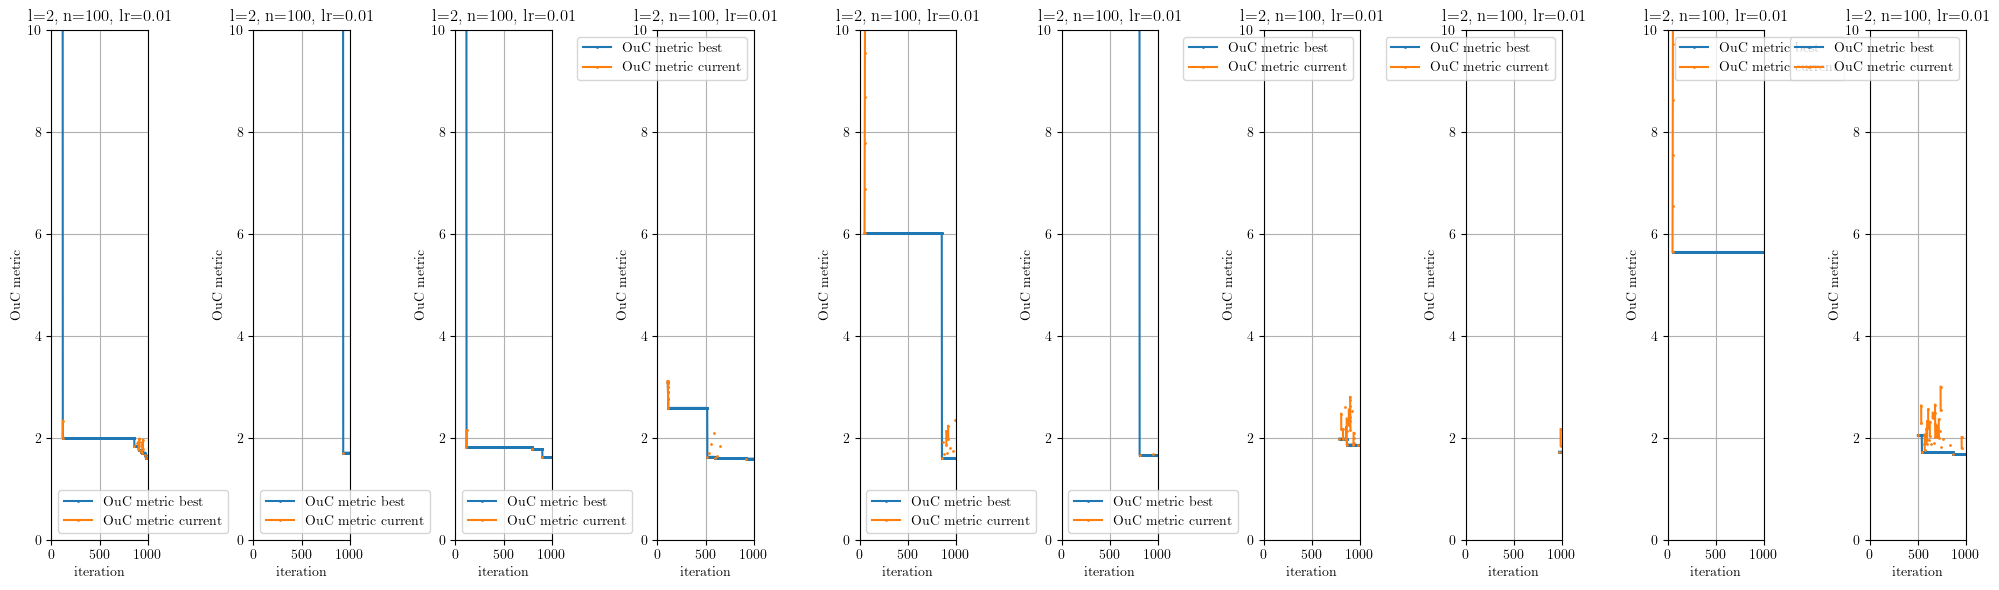

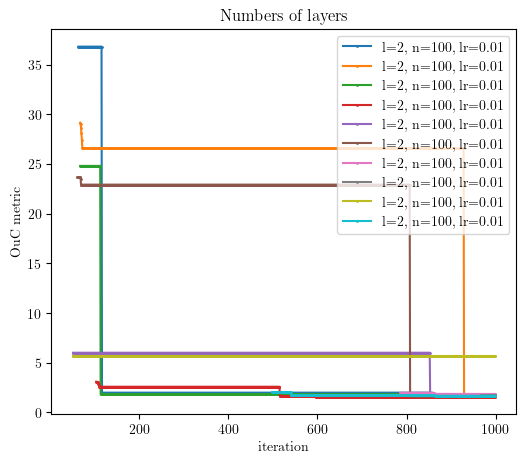

In [34]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7362335 MSE solution: 0.008011118005301724 ratio: 0.016 time: 106.89830589294434
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6509036 MSE solution: 0.011507649493377356 ratio: 0.013 time: 105.58875036239624
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6155072 MSE solution: 0.0022664127388319247 ratio: 0.02 time: 106.57257652282715
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 17.825462 MSE solution: 6.154083334346276 ratio: 0.006 time: 106.03861594200134
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5793337 MSE solution: 0.01843836963268977 ratio: 0.005 time: 108.46929907798767
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9525211 MSE solution: 0.04129990214293381 ratio: 0.002 time: 108.10998678207397
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.0228990887814888 ratio: 0.0 time: 107.48010921478271
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.0033329482460567 ratio: 0.0 time: 106.12957501411438
LAYERS: 2 NEURONS: 100 LR: 0.01 e

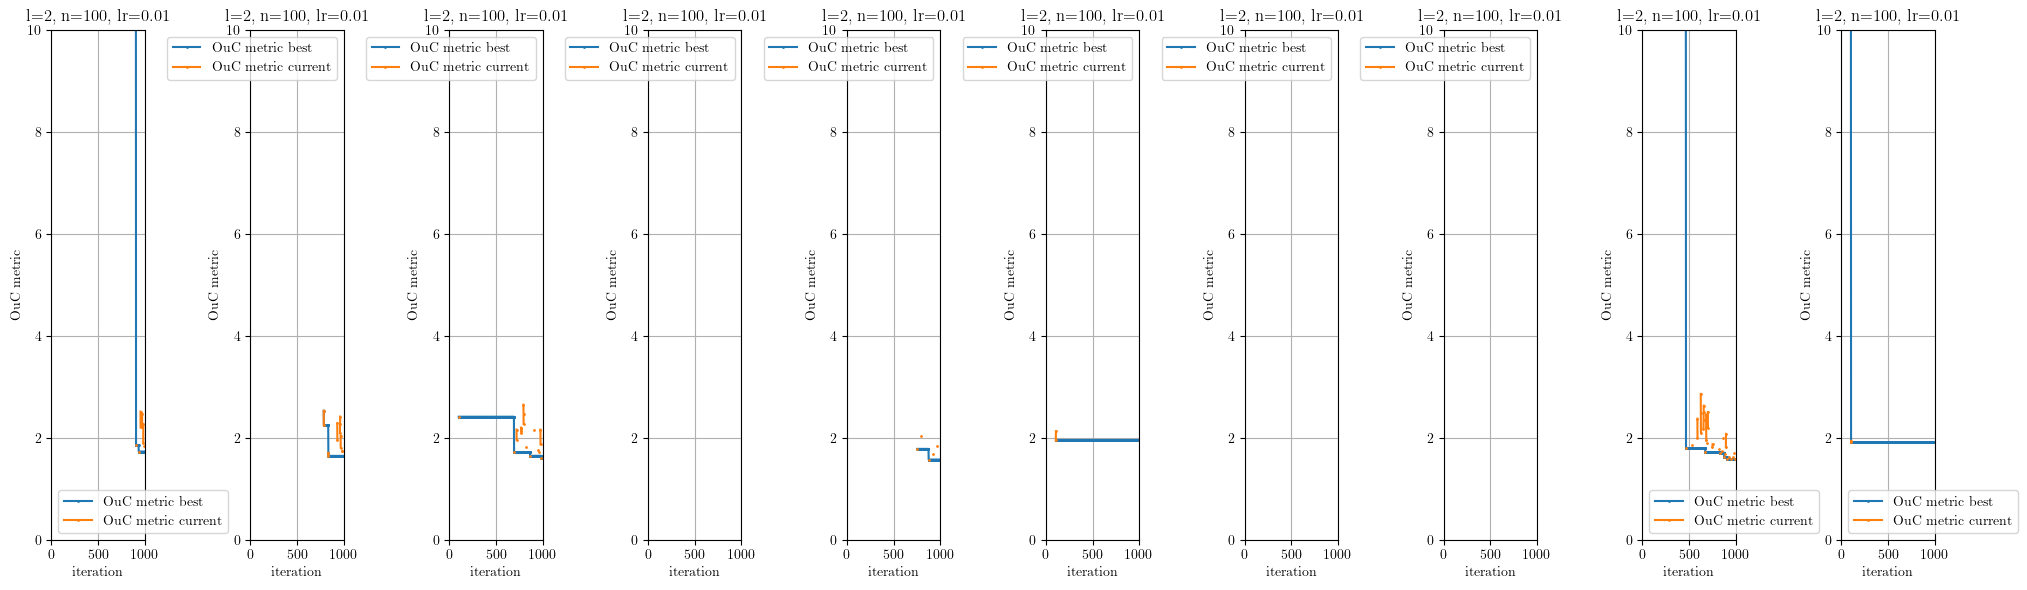

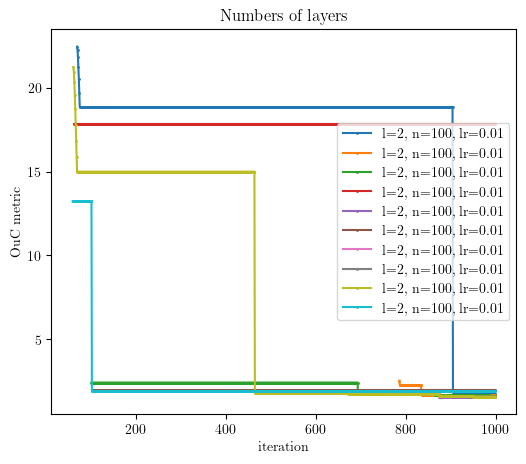

In [35]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0948956 MSE solution: 0.05335611939795776 ratio: 0.007 time: 96.96523451805115
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 30.075401 MSE solution: 12.667030040122611 ratio: 0.002 time: 96.09441351890564
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 8.220943 MSE solution: 1.8926773504109766 ratio: 0.002 time: 96.74154019355774
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 22.513336 MSE solution: 8.583274478993598 ratio: 0.003 time: 90.46327018737793
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 17.589148 MSE solution: 6.777579013454094 ratio: 0.012 time: 92.85789632797241
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7518557 MSE solution: 0.018780193501470335 ratio: 0.01 time: 92.94750332832336
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 28.014994 MSE solution: 11.810565940710456 ratio: 0.005 time: 90.45520615577698
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.598336 MSE solution: 0.008445062522187215 ratio: 0.007 time: 94.99485111236572
LAYERS: 2 NEURONS: 100 LR: 0.01 

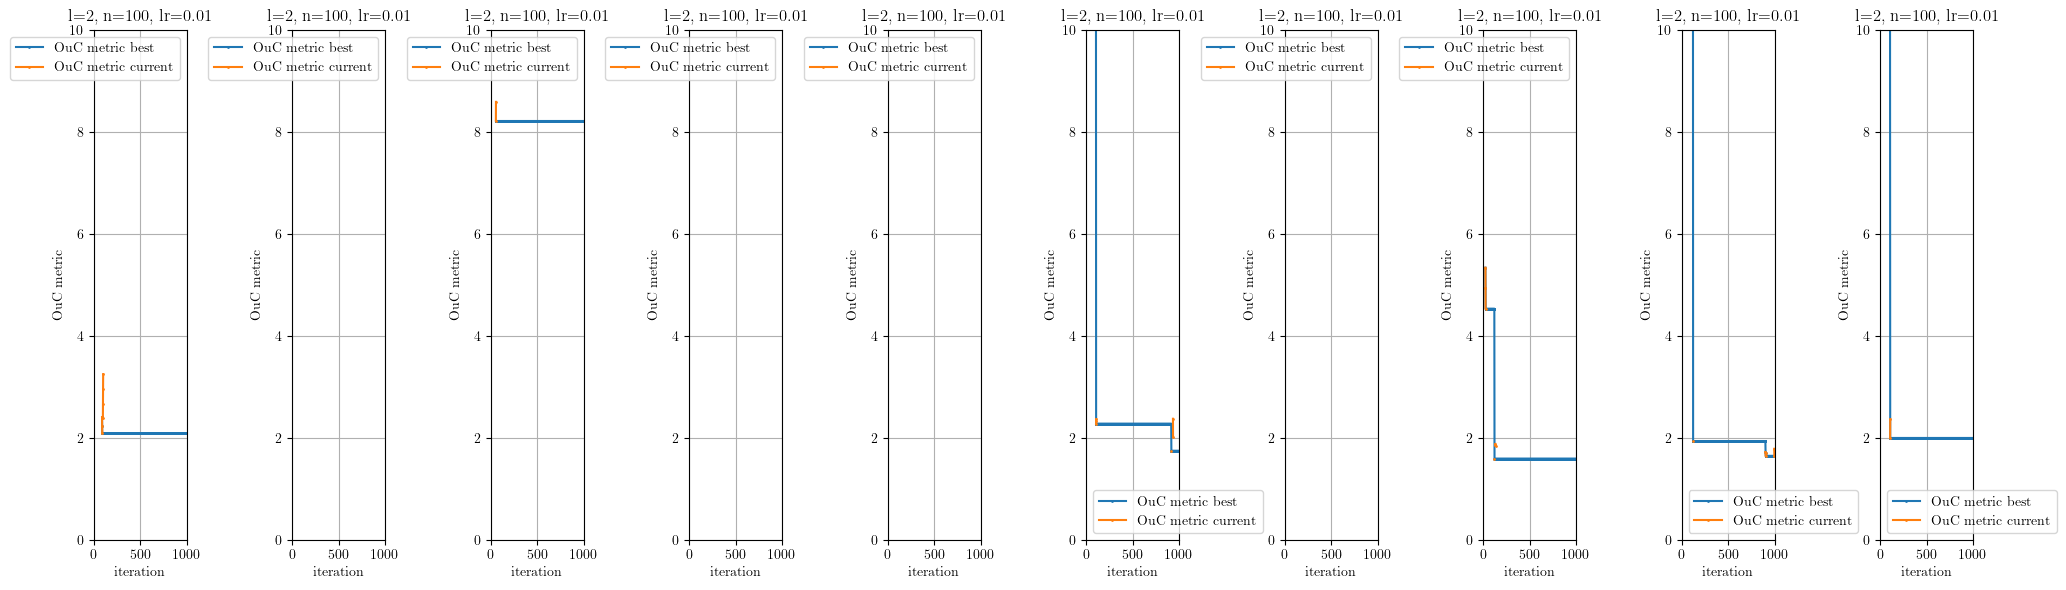

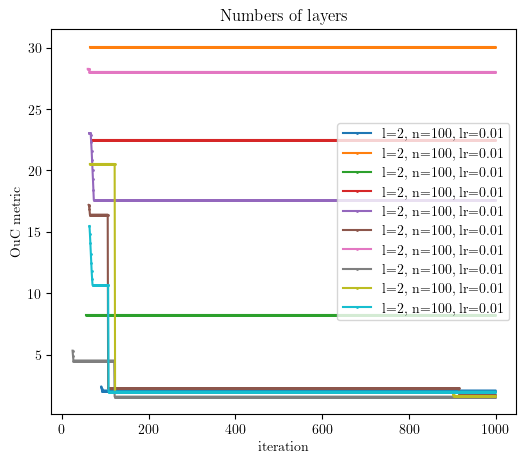

In [36]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5654781 MSE solution: 0.004170611588065726 ratio: 0.034 time: 90.70480251312256
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5662105 MSE solution: 0.004133616018634955 ratio: 0.007 time: 91.82802391052246
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.4243546 MSE solution: 0.08572436649812865 ratio: 0.006 time: 91.21885538101196
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7260269 MSE solution: 0.0060838276079046155 ratio: 0.039 time: 93.49775576591492
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5170766 MSE solution: 0.001329404185114877 ratio: 0.015 time: 95.8674807548523
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.664096 MSE solution: 0.013336146543873642 ratio: 0.019 time: 94.73146080970764
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 7.755731 MSE solution: 2.3264039797683833 ratio: 0.007 time: 100.89586687088013
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 0.6521486428501256 ratio: 0.0 time: 96.51049304008484
LAYERS: 2 NEURONS: 100 LR: 0.0

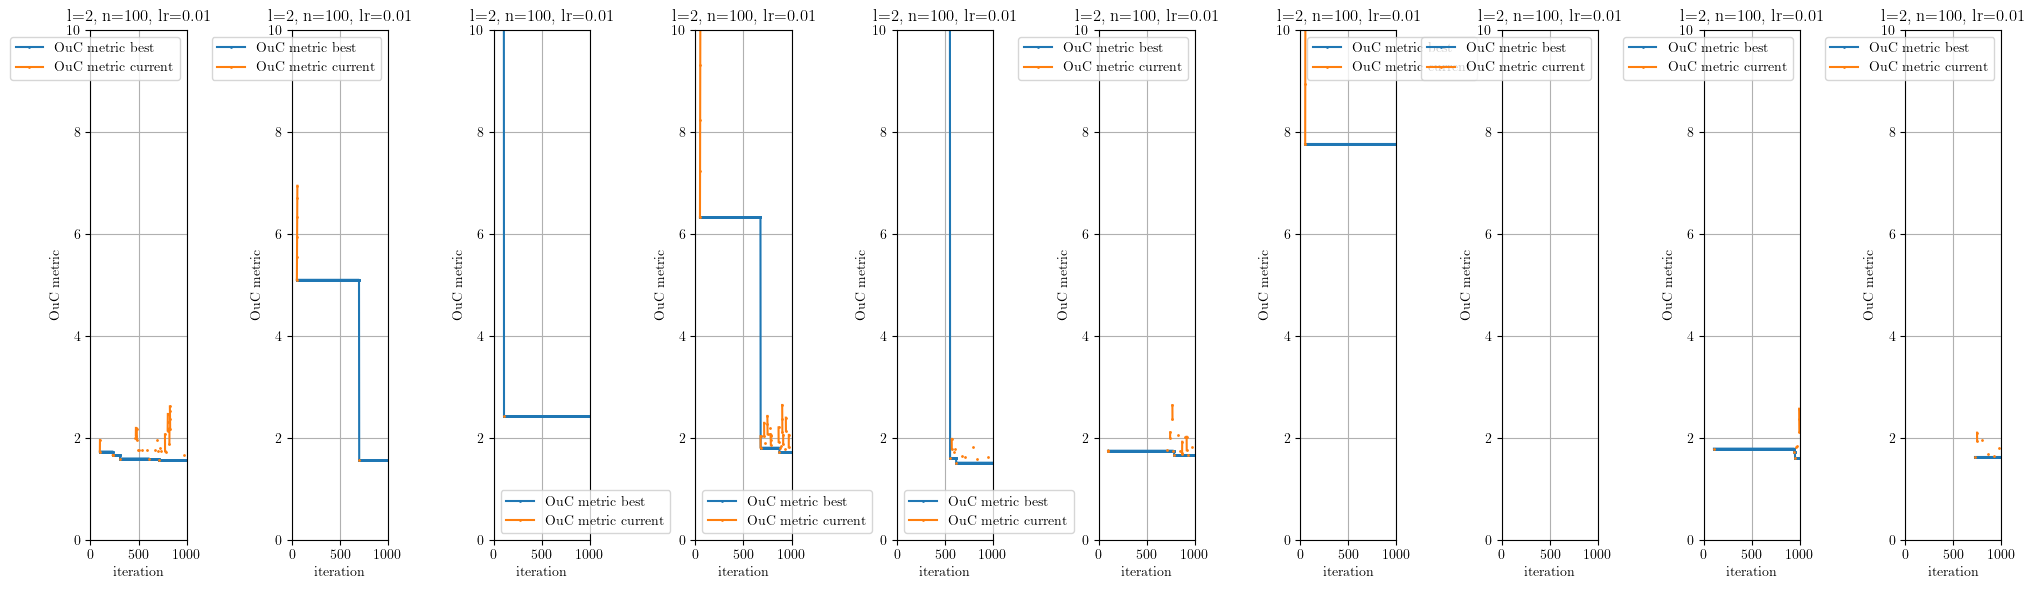

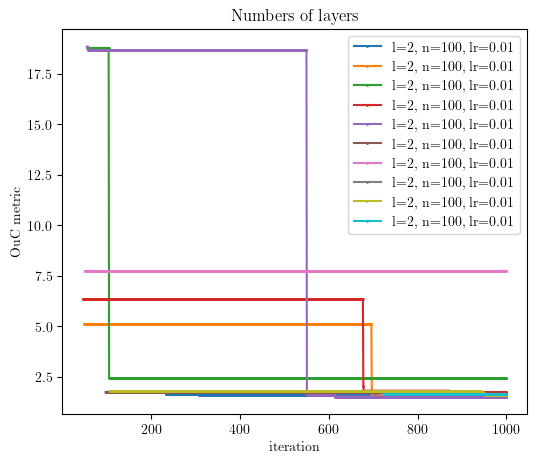

In [37]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5254401 MSE solution: 0.005788563036165953 ratio: 0.014 time: 94.38326120376587
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7356309 MSE solution: 0.044051691848328224 ratio: 0.001 time: 98.19479537010193
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7815604 MSE solution: 0.021616479181086043 ratio: 0.013 time: 101.06639885902405
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7459649 MSE solution: 0.006726151064569009 ratio: 0.01 time: 98.24808430671692
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7534921 MSE solution: 0.06546511636273875 ratio: 0.008 time: 99.21816635131836
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.2742130201736448 ratio: 0.0 time: 100.21041321754456
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7159516 MSE solution: 0.0064976504469898 ratio: 0.017 time: 102.80464744567871
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6331446 MSE solution: 0.022687415024055895 ratio: 0.025 time: 99.11851286888123
LAYERS: 2 NEURONS: 100 LR: 

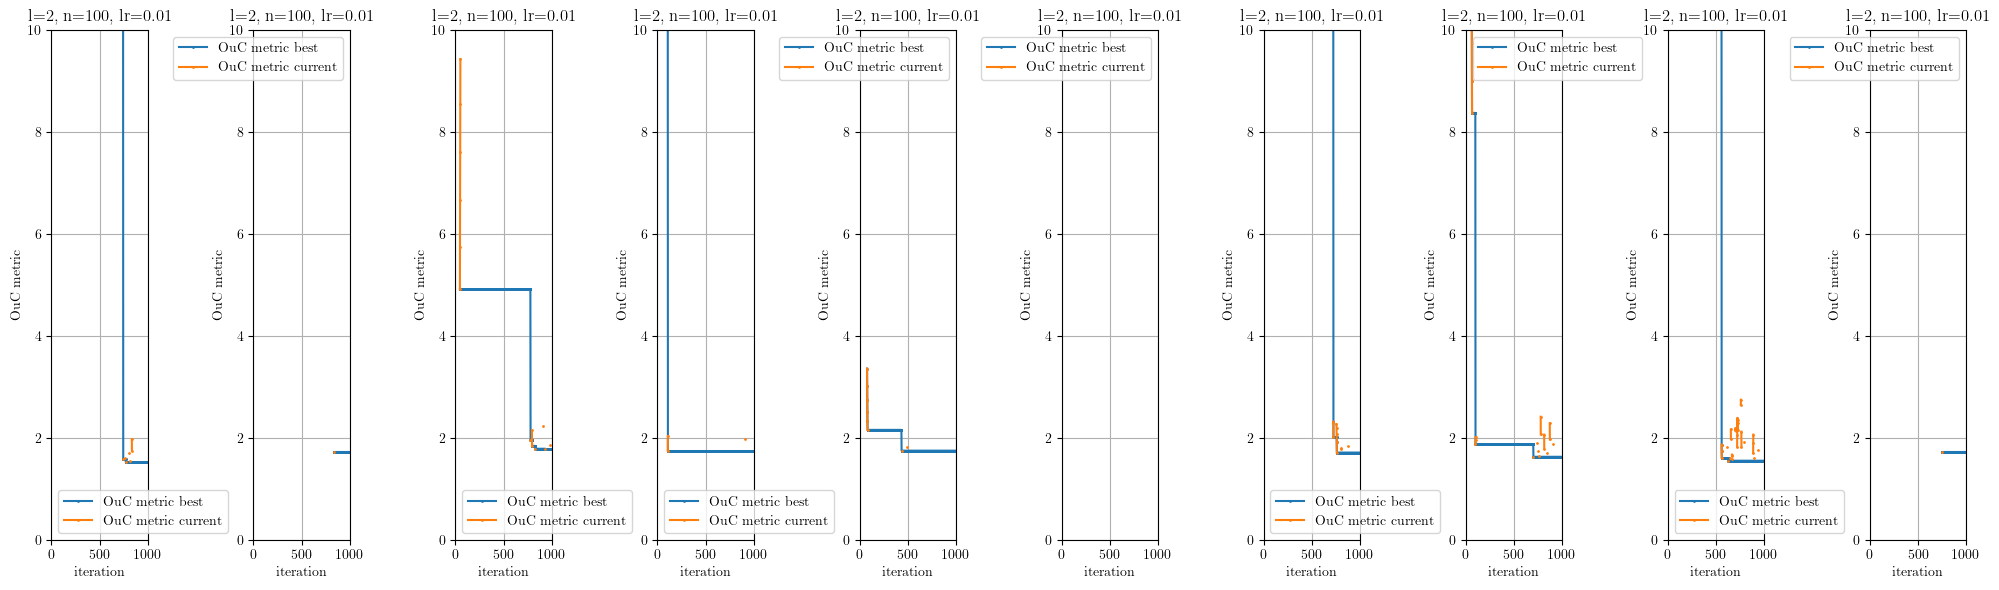

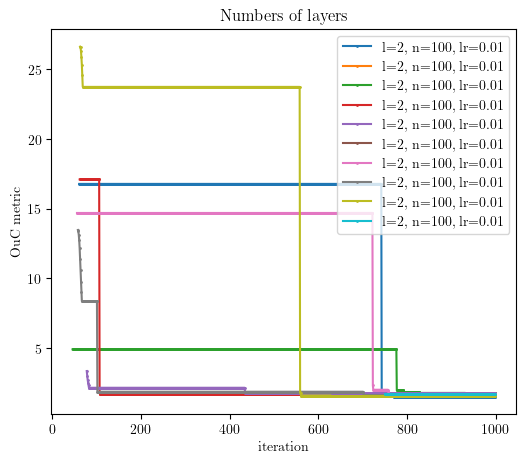

In [38]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6789091 MSE solution: 0.019353202802530167 ratio: 0.008 time: 98.02054953575134
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 16.124857 MSE solution: 5.49359559316812 ratio: 0.001 time: 98.78395771980286
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5595094 MSE solution: 0.002648558730306099 ratio: 0.018 time: 98.86666226387024
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6301328 MSE solution: 0.002573729476320399 ratio: 0.012 time: 98.23762726783752
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5960109 MSE solution: 0.011907067093538335 ratio: 0.017 time: 99.46950387954712
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5746917 MSE solution: 0.025528719014997578 ratio: 0.023 time: 102.01903867721558
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.3961306 MSE solution: 0.10909079368046204 ratio: 0.01 time: 100.02752780914307
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7495657 MSE solution: 0.04604656019768411 ratio: 0.005 time: 99.51570796966553
LAYERS: 2 NEURONS: 10

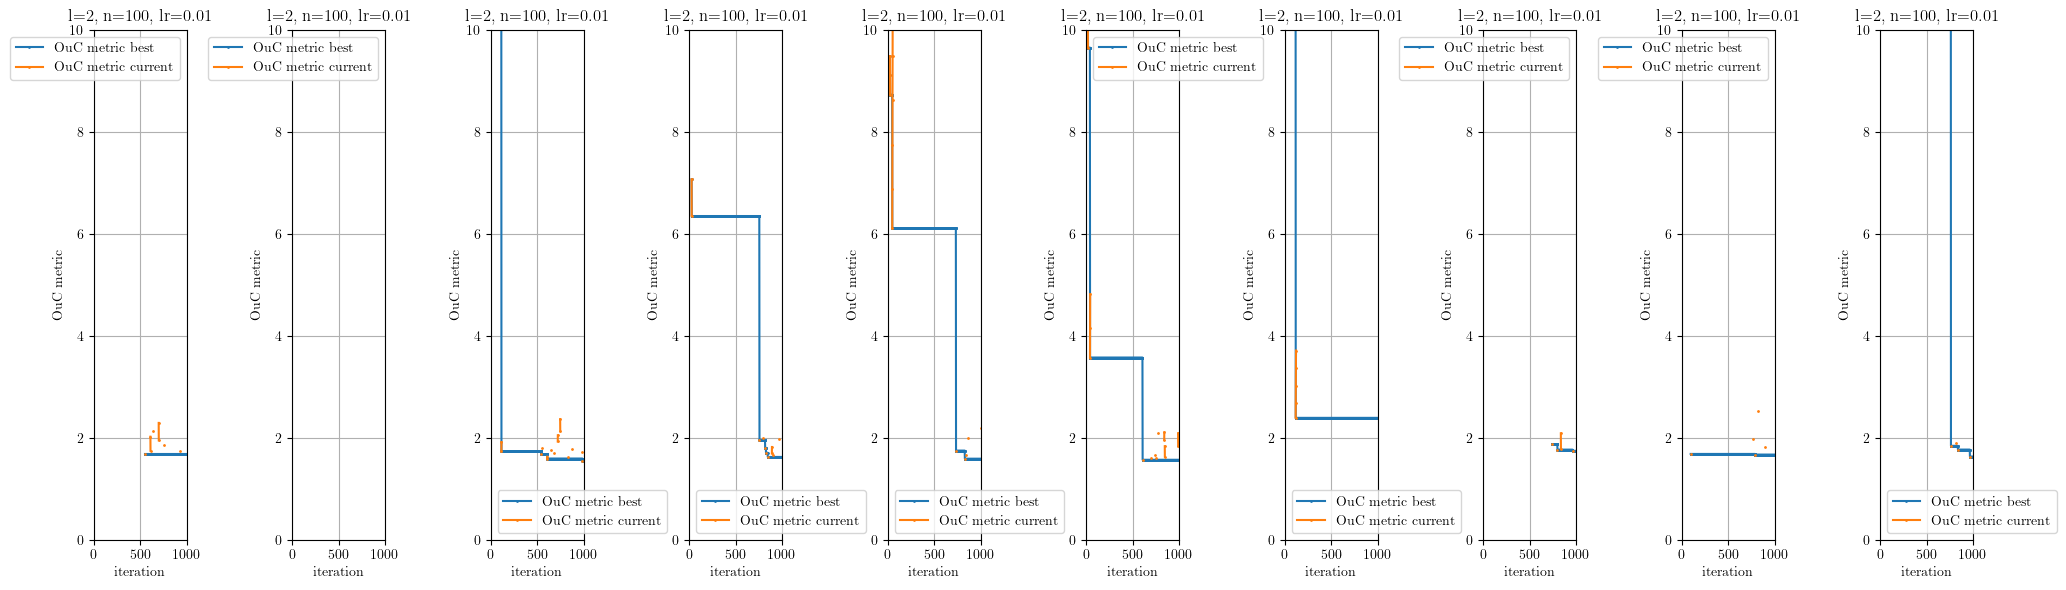

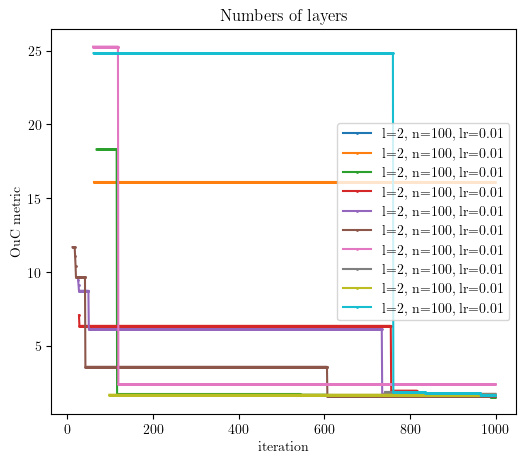

In [39]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6735715 MSE solution: 0.007495899344443602 ratio: 0.011 time: 98.24346971511841
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.639241 MSE solution: 0.0039906207840383345 ratio: 0.045 time: 98.2062451839447
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6562194 MSE solution: 0.0026333417342524687 ratio: 0.012 time: 99.0561773777008
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5364817 MSE solution: 0.0018534207974723845 ratio: 0.009 time: 102.56237888336182
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6353337 MSE solution: 0.006505574058276211 ratio: 0.008 time: 101.25634694099426
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5615982 MSE solution: 0.007975452651487575 ratio: 0.023 time: 100.18890643119812
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5955523 MSE solution: 0.017481711861398967 ratio: 0.013 time: 103.96659421920776
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 19.86863 MSE solution: 7.282079434463071 ratio: 0.003 time: 100.72400617599487
LAYERS: 2 NEURO

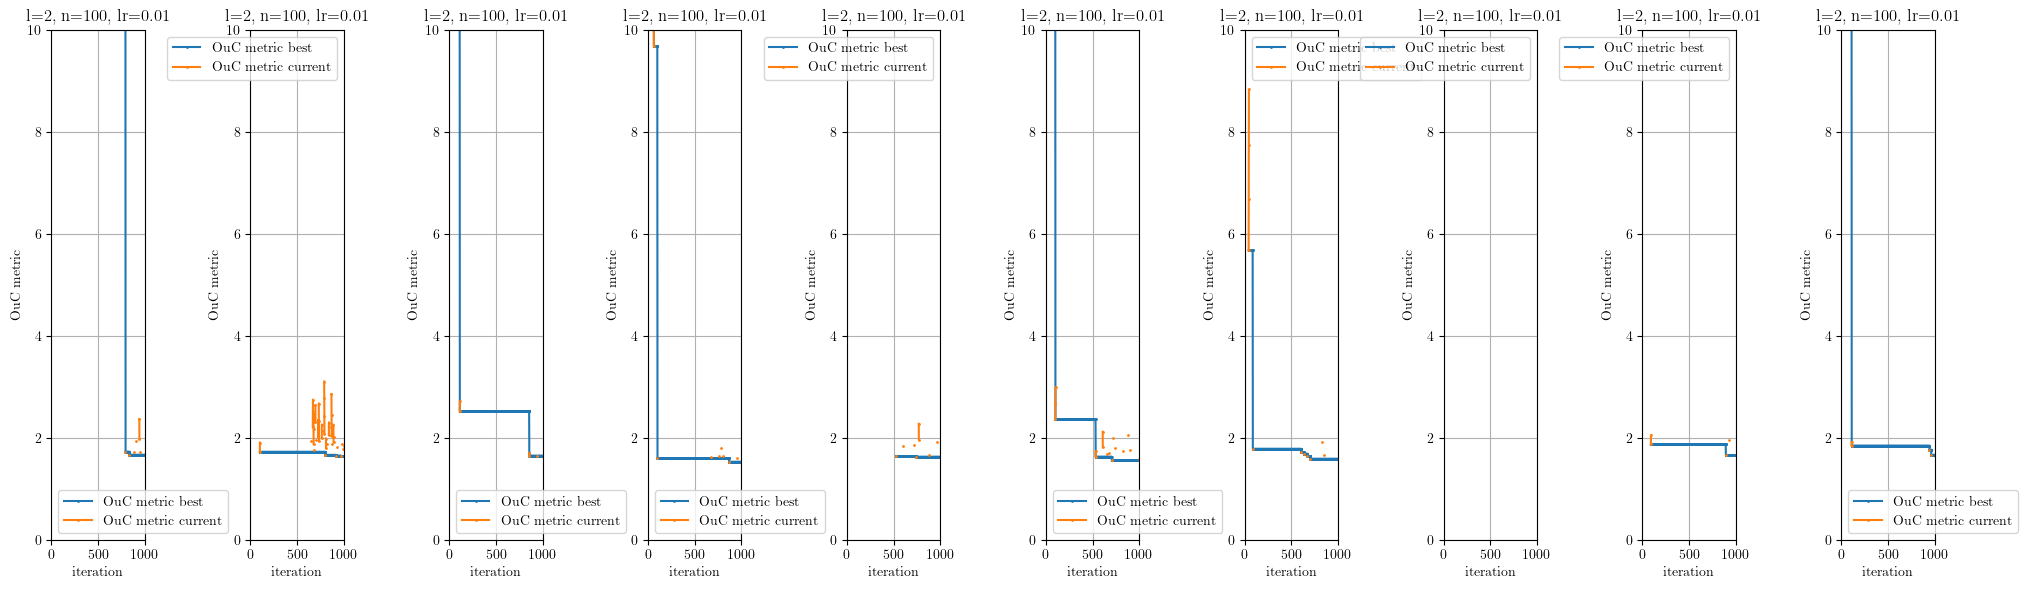

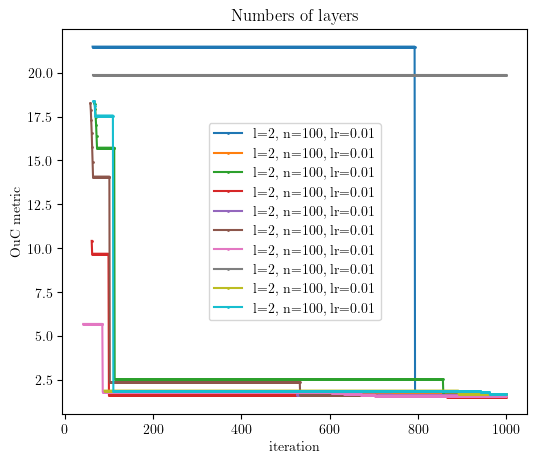

In [40]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5695043 MSE solution: 0.02669032544270511 ratio: 0.007 time: 99.19882154464722
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.721614 MSE solution: 0.031965463323742456 ratio: 0.016 time: 99.15395832061768
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8766536 MSE solution: 0.04844396247739361 ratio: 0.004 time: 98.97513437271118
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5952462 MSE solution: 0.023513355902127202 ratio: 0.016 time: 101.69621157646179
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5888889 MSE solution: 0.0008612535832265645 ratio: 0.015 time: 99.22616267204285
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5412627 MSE solution: 0.0019001195074298477 ratio: 0.015 time: 102.53428339958191
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5985575 MSE solution: 0.005163528356001122 ratio: 0.021 time: 98.37686347961426
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6254098 MSE solution: 0.005898336097519386 ratio: 0.014 time: 98.89911532402039
LAYERS: 2 NEURO

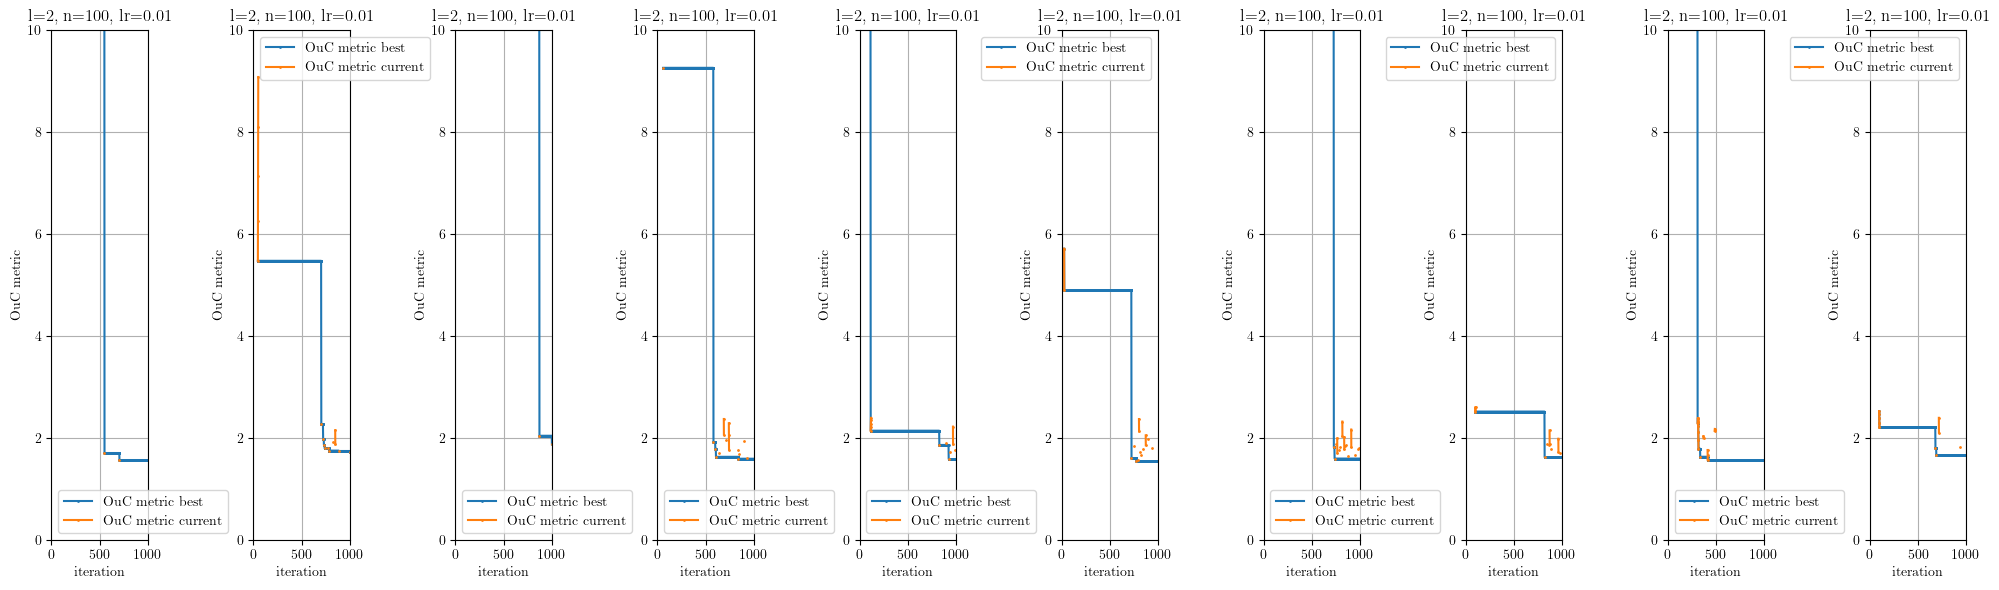

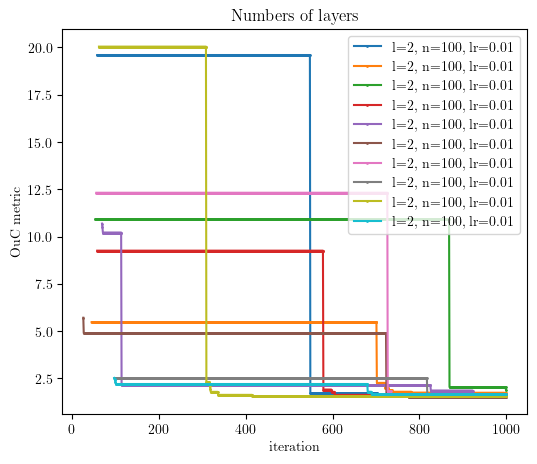

In [41]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5318855 MSE solution: 0.0074752887830938815 ratio: 0.017 time: 101.3213415145874
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7464051 MSE solution: 0.03720326596774866 ratio: 0.001 time: 98.449716091156
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.082377 MSE solution: 0.08437722496153977 ratio: 0.001 time: 99.78609824180603
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.090792760331146 ratio: 0.0 time: 98.5831732749939
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6292719 MSE solution: 0.036230833484126646 ratio: 0.003 time: 100.35077381134033
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.8629271 MSE solution: 0.0665053100123585 ratio: 0.001 time: 100.55548119544983
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.7294487222328743 ratio: 0.0 time: 97.57870388031006
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5969617 MSE solution: 0.010236193238227978 ratio: 0.013 time: 101.70009589195251
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 

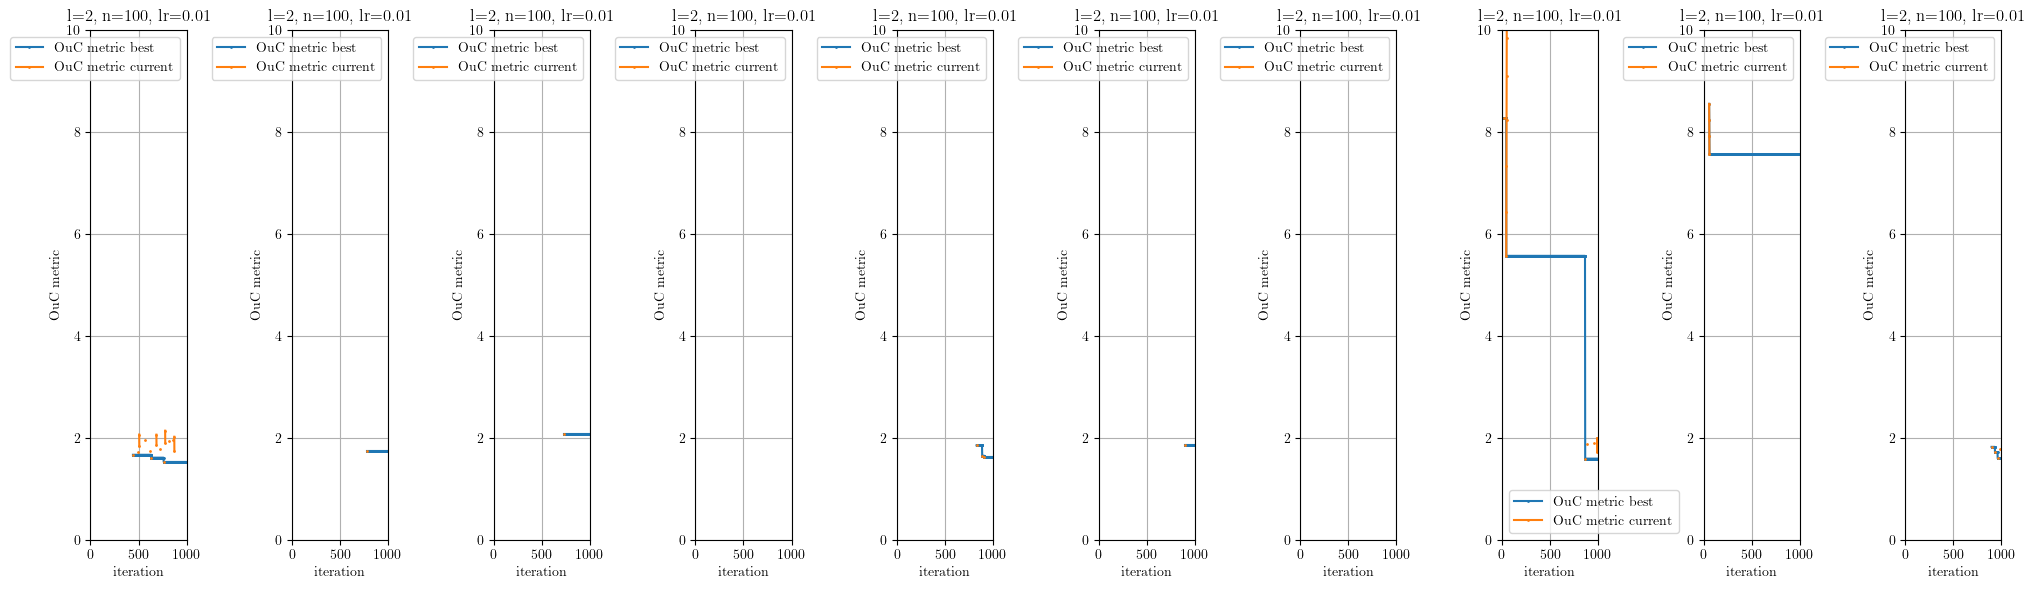

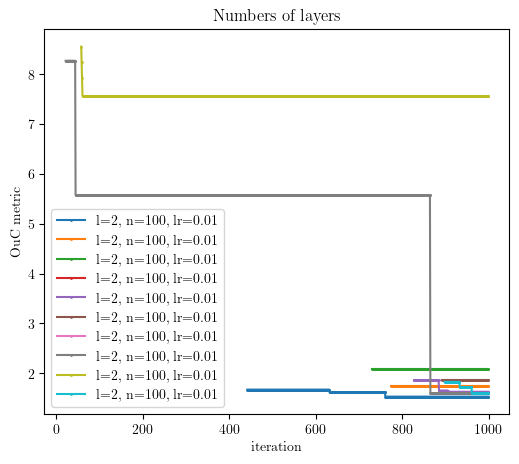

In [42]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6186031 MSE solution: 0.006254861005700424 ratio: 0.034 time: 104.15787959098816
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5366366 MSE solution: 0.0002883541510880036 ratio: 0.019 time: 99.38385534286499
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6485479 MSE solution: 0.02710365009788875 ratio: 0.001 time: 98.33864903450012
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 6.877507 MSE solution: 1.4287935716883915 ratio: 0.001 time: 100.04127645492554
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.3666553339006338 ratio: 0.0 time: 102.68887448310852
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.2064947878180752 ratio: 0.0 time: 99.48537564277649
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.9930809 MSE solution: 0.04557675293566705 ratio: 0.002 time: 99.83850908279419
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5859419 MSE solution: 0.005243513678076687 ratio: 0.016 time: 103.19793915748596
LAYERS: 2 NEURONS: 100 LR: 0.01 epsi

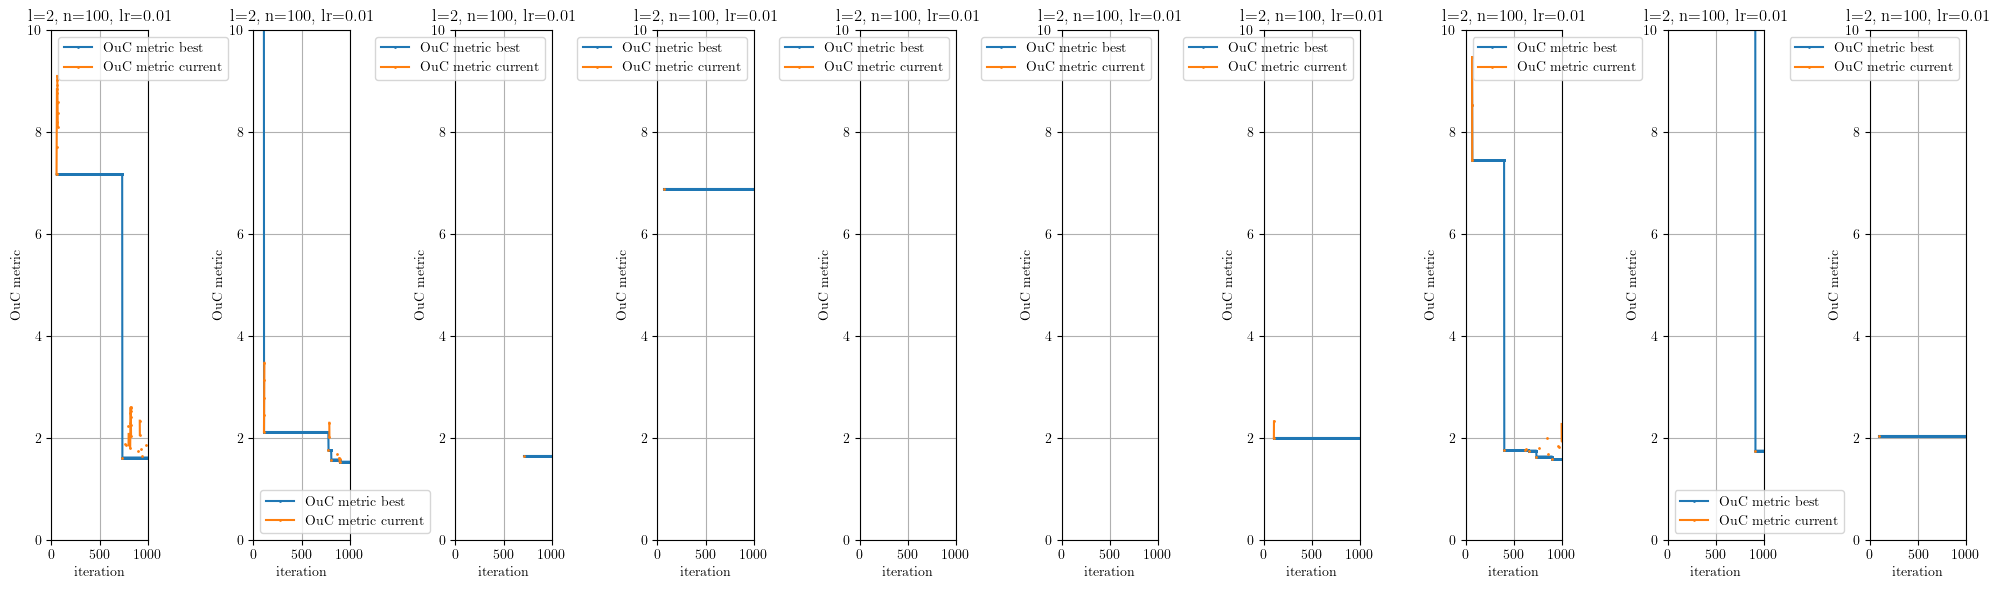

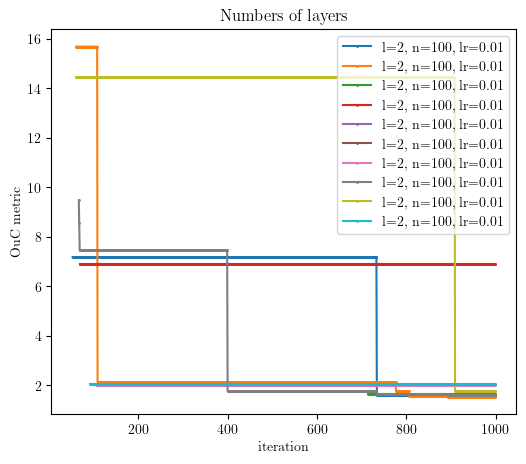

In [43]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5907545 MSE solution: 0.019153528457331783 ratio: 0.026 time: 101.20189547538757
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.2744874114719063 ratio: 0.0 time: 99.65821290016174
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6286688 MSE solution: 0.015343115303501168 ratio: 0.014 time: 99.3074836730957
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7327701 MSE solution: 0.007107406184880237 ratio: 0.008 time: 101.60374712944031
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5824217 MSE solution: 0.012249322364542419 ratio: 0.01 time: 98.33590960502625
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.4858324309027833 ratio: 0.0 time: 97.8852162361145
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5618516 MSE solution: 0.001994182935158537 ratio: 0.016 time: 101.69918537139893
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.967116 MSE solution: 1.0457082247586242 ratio: 0.002 time: 103.45829916000366
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilo

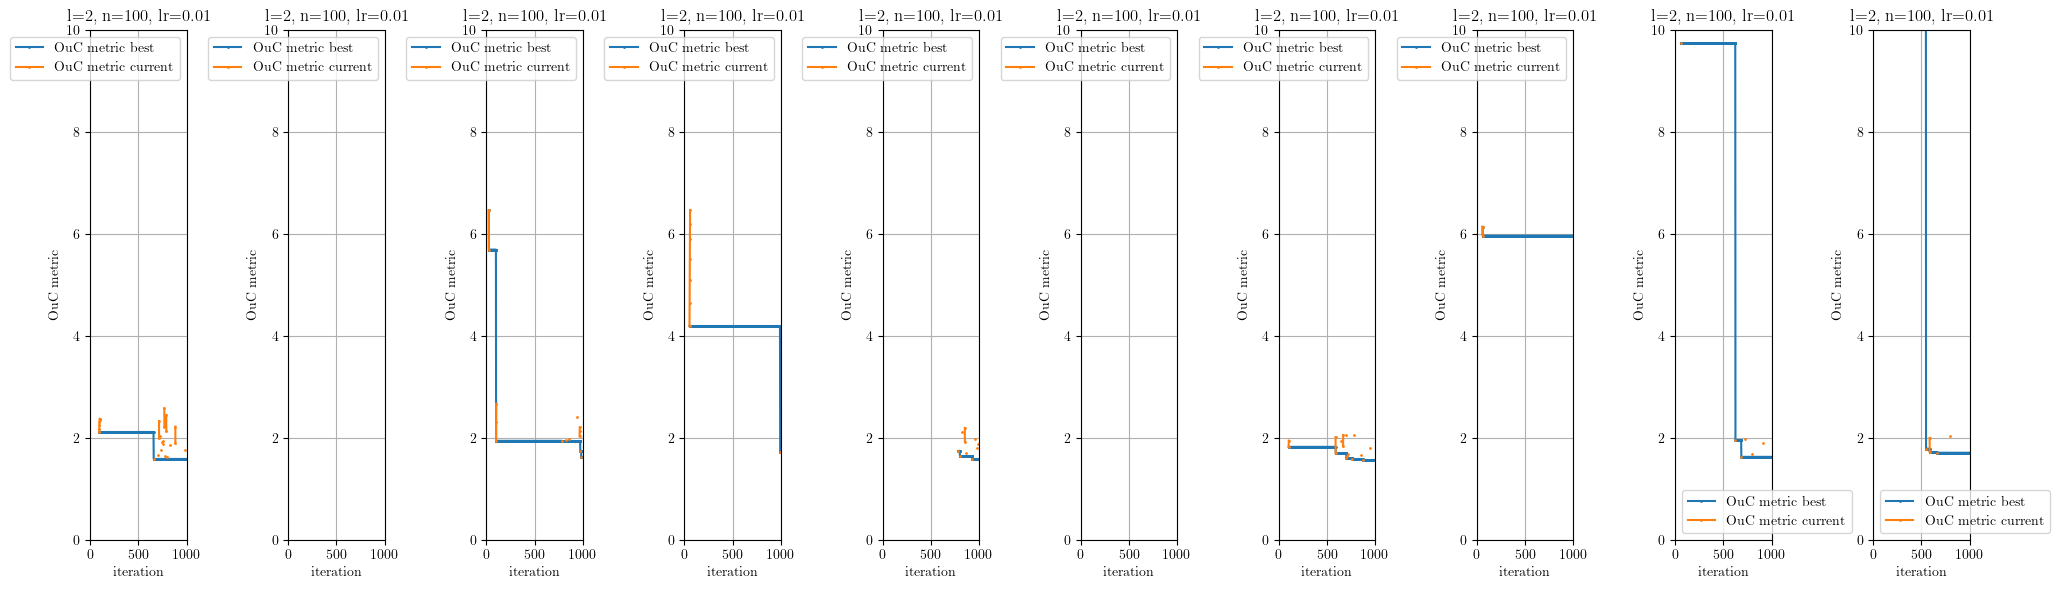

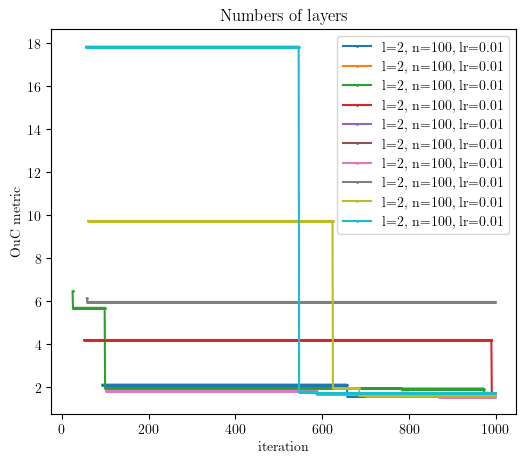

In [44]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.652383 MSE solution: 1.4631981862097814 ratio: 0.001 time: 100.56373262405396
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7145244 MSE solution: 0.035001665621755586 ratio: 0.015 time: 100.95163488388062
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.63520127096345 ratio: 0.0 time: 98.6201958656311
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.782888 MSE solution: 0.04430926395934762 ratio: 0.002 time: 97.25959849357605
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6556835 MSE solution: 0.008916607249671457 ratio: 0.015 time: 98.10803961753845
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7727258 MSE solution: 0.03498755271628022 ratio: 0.007 time: 99.19900107383728
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 0.9546325336275374 ratio: 0.0 time: 98.31360149383545
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 1.3179193050509825 ratio: 0.0 time: 97.06790232658386
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5464857 MS

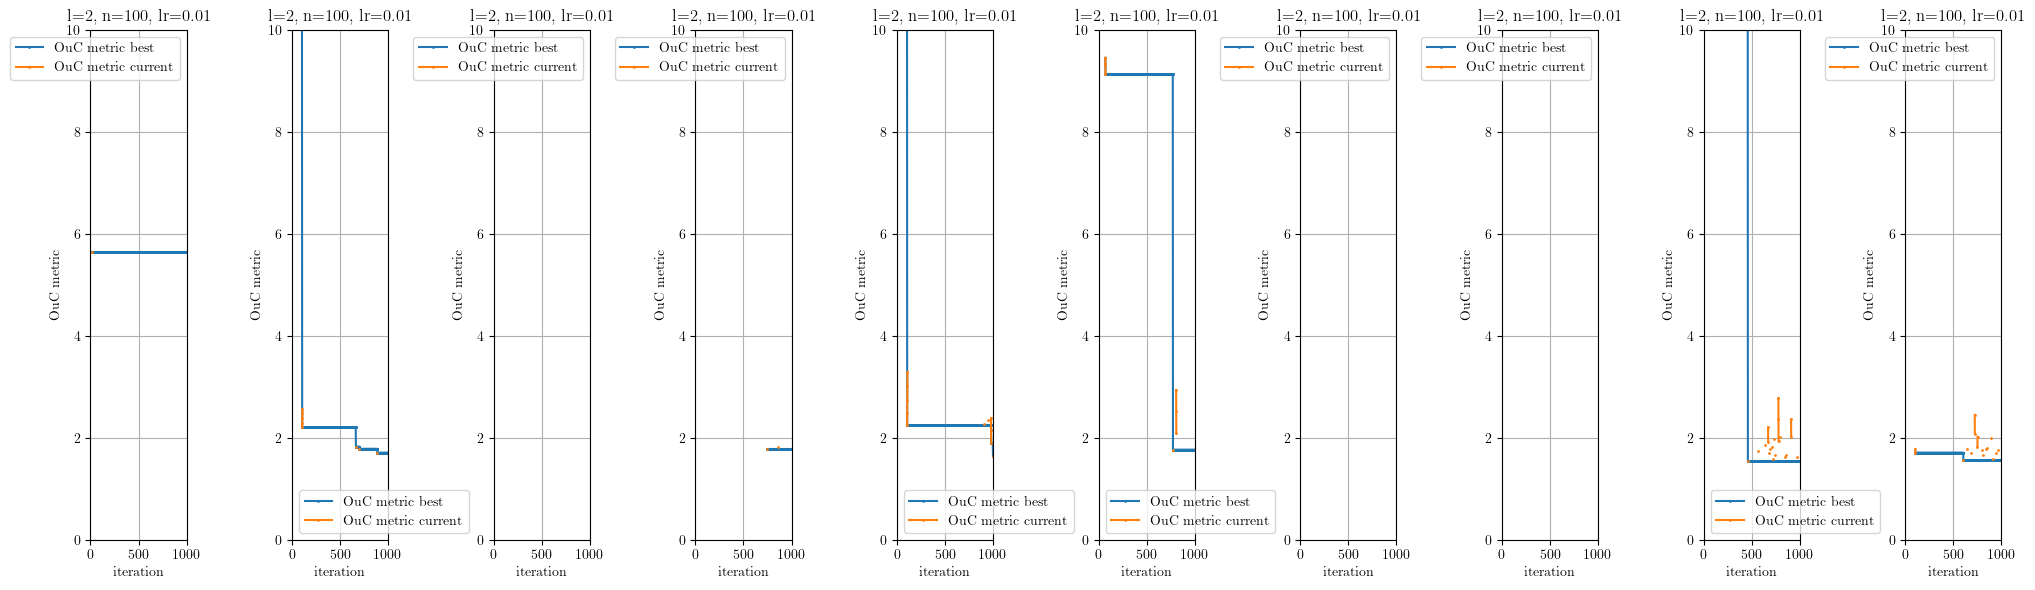

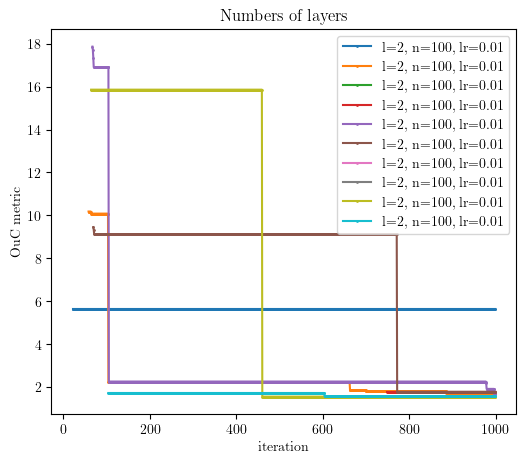

In [45]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6095029 MSE solution: 0.015190102281178652 ratio: 0.014 time: 99.63527393341064
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6275096 MSE solution: 0.017479310685453105 ratio: 0.025 time: 96.72581553459167
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5465473 MSE solution: 0.01695342438939296 ratio: 0.009 time: 96.03230237960815
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6886559 MSE solution: 0.045494211441860145 ratio: 0.008 time: 98.33535647392273
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0804415 MSE solution: 0.09158365003733593 ratio: 0.013 time: 100.51376962661743
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5713753 MSE solution: 0.025653057467834455 ratio: 0.006 time: 97.21557855606079
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.614545 MSE solution: 0.015289356466027262 ratio: 0.018 time: 98.88402652740479
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6157881 MSE solution: 0.03247655309538305 ratio: 0.003 time: 98.1095118522644
LAYERS: 2 NEURONS: 1

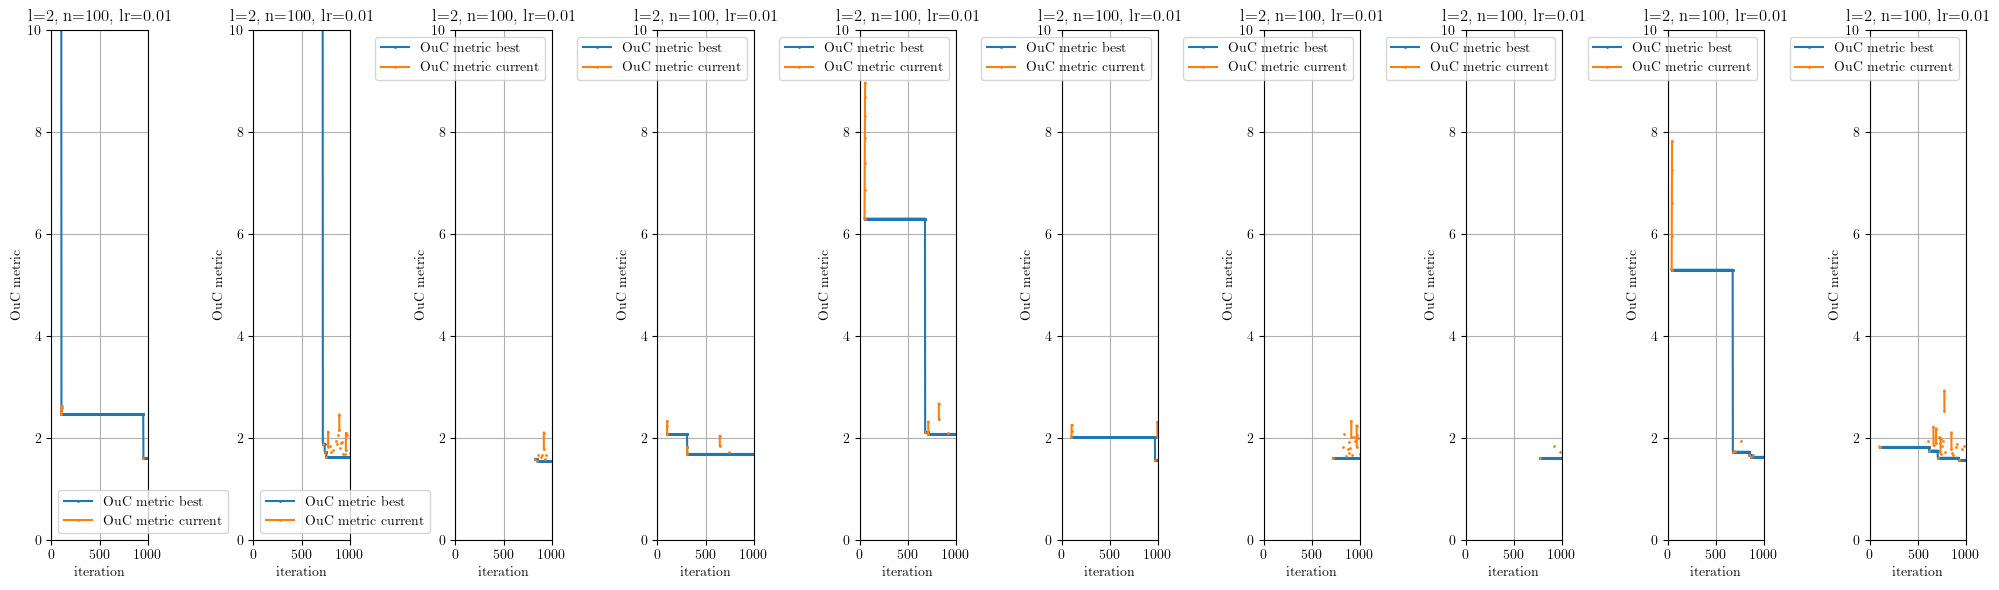

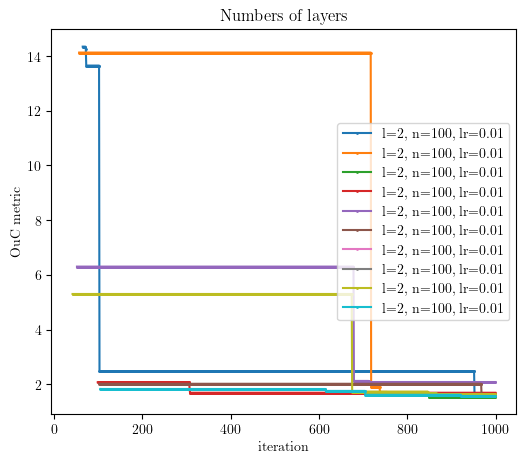

In [46]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5896956 MSE solution: 0.0009511514084161711 ratio: 0.015 time: 98.87521576881409
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5575758 MSE solution: 0.004634477870910918 ratio: 0.011 time: 99.40660047531128
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5650079 MSE solution: 0.015166802330106031 ratio: 0.011 time: 101.92721176147461
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5456206 MSE solution: 0.0005218501846804721 ratio: 0.015 time: 102.16954278945923
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.635811 MSE solution: 0.005796255175653925 ratio: 0.012 time: 99.77142310142517
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6053858 MSE solution: 0.0034562850118800806 ratio: 0.055 time: 101.44790124893188
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6116132 MSE solution: 0.014730982834523385 ratio: 0.001 time: 102.81266665458679
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 7.4811125 MSE solution: 1.7738640324814268 ratio: 0.009 time: 99.4655408859253
LAYERS: 2 NEU

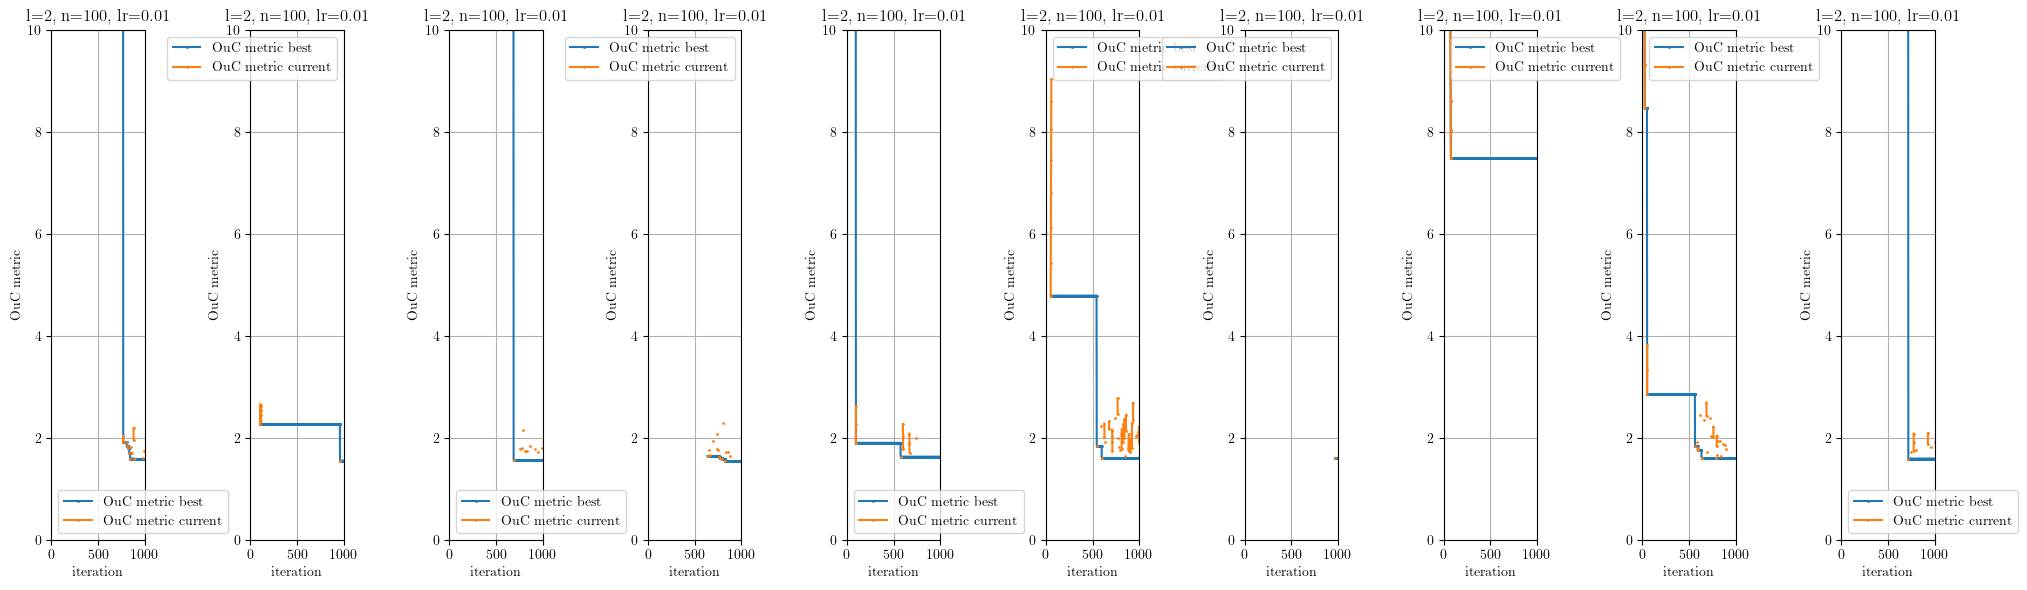

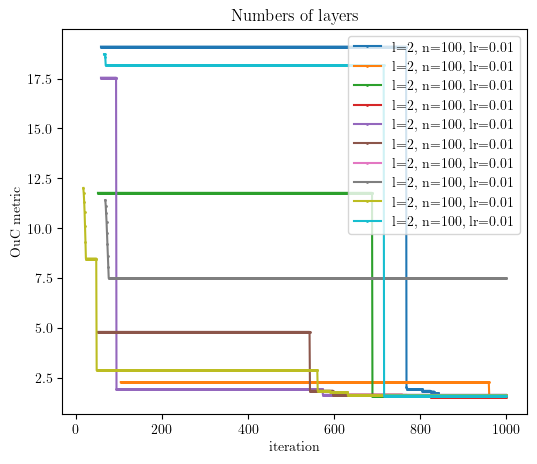

In [47]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_700282/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_700282/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.528673 MSE solution: 0.005077107925337553 ratio: 0.015 time: 96.09369254112244
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5477693 MSE solution: 0.0038870984804825833 ratio: 0.008 time: 99.17421984672546
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6738293 MSE solution: 0.010347206158344136 ratio: 0.008 time: 101.09445595741272
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.6197697 MSE solution: 0.029043959968657104 ratio: 0.015 time: 99.91783857345581
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5870147 MSE solution: 0.002637892754481746 ratio: 0.007 time: 101.32039618492126
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5281355 MSE solution: 0.00016266672985893954 ratio: 0.031 time: 99.63040471076965
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5967295 MSE solution: 0.0014667353159390495 ratio: 0.001 time: 99.47227764129639
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5535063 MSE solution: 0.00289715960293277 ratio: 0.024 time: 100.62546253204346
LAYERS: 2 N

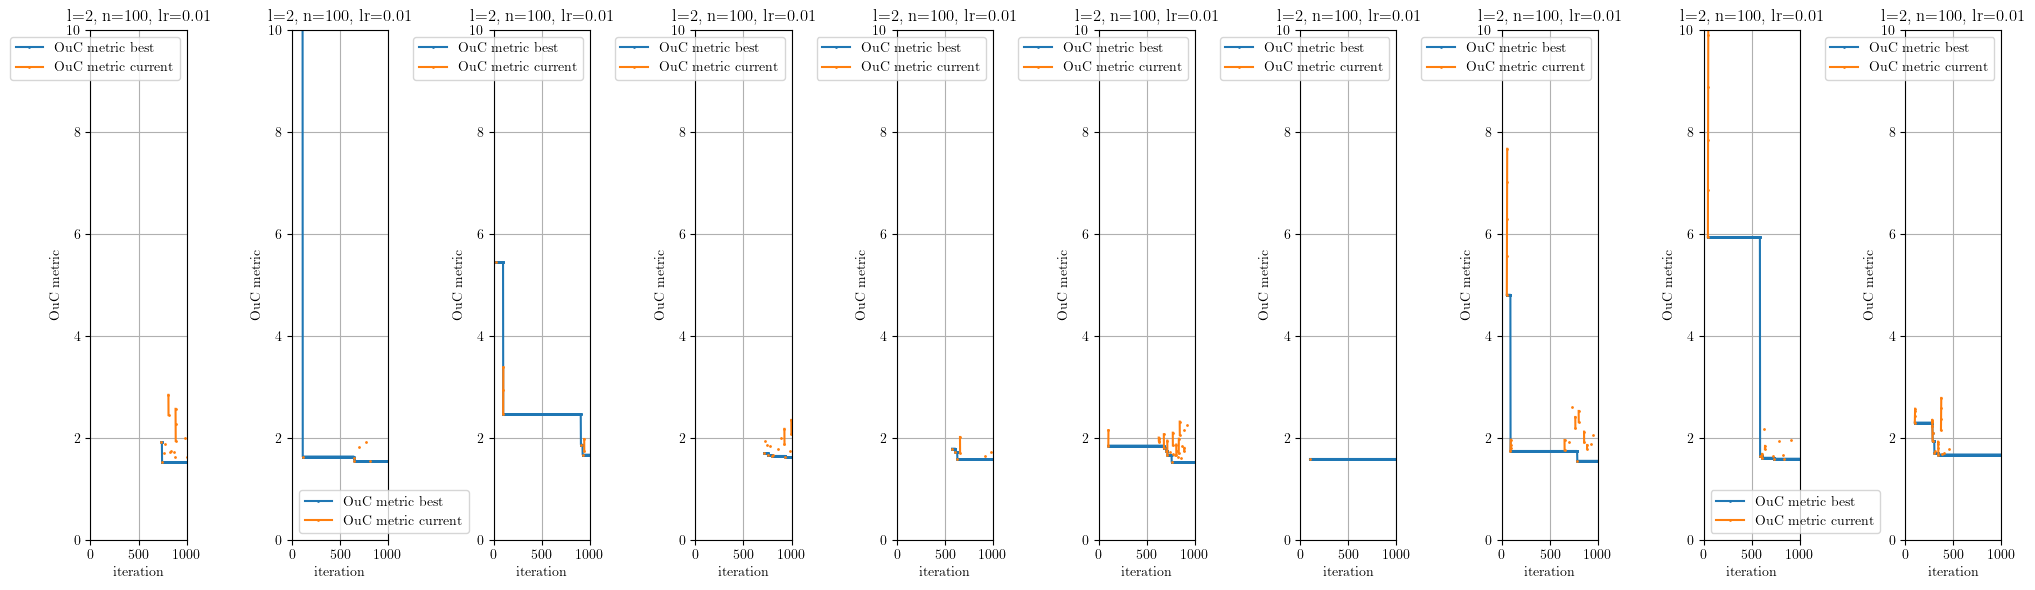

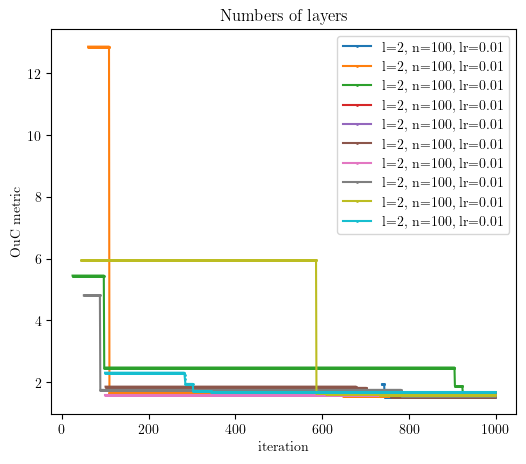

In [48]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [49]:
import plotly.express as px
import pandas as pd

# Convert the list of hyperparameter combinations into a DataFrame
df = pd.DataFrame(hyperparameter_combinations)

# Create an interactive scatter plot with ratio_mean on x-axis and error_mean on y-axis
fig = px.scatter(df, 
                 x='error_mean', 
                 y='ratio_mean', 
                 hover_data=['WEIGHTING', 'CONSTRAINT_WEIGHT'],
                 labels={
                     'ratio_mean': 'Ratio Mean',
                     'error_mean': 'Error Mean'
                 },
                 title='Hyperparameter Tuning: Ratio Mean vs. Error Mean')

# Show the interactive plot
fig.show()

In [50]:
from IPython.display import display
display(df.sort_values('error_mean', ascending=True).style.set_table_attributes('class="table table-hover"'))